# Import Libraries

In [ ]:
!pip install nilearn nipype SimpleITK pingouin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nilearn
from google.colab import auth
from google.cloud import storage
import nibabel as nib
from scipy import interpolate
from nilearn import image, plotting
from nilearn.image import index_img
import os
import scipy.stats as stats
import pingouin as pg

# Upload Files (run only on the first time)

In [ ]:
# Authenticate with Google Cloud
auth.authenticate_user()

# Initialize the Google Cloud Storage client
client = storage.Client()

# Set bucket name
bucket_name = 'dsprojectdata'
bucket = client.get_bucket(bucket_name)

# Defining the base folder path
base_path = 'ds003550'

In [ ]:
# Creating a dictionary to store the categorized file paths

# Function to classify files into groups
def classify_files_func():
    for sub_id in range(1,39):
        sub_folder = f'sub-sc{sub_id:03d}'
        func_folder = f'{base_path}/{sub_folder}/func'

        # Listing all the files in the 'eeg' folder for each subject
        blobs = bucket.list_blobs(prefix=func_folder)

        # Iterating through all the files
        for blob in blobs:
            file_name = blob.name
            file_path = f'gs://{bucket_name}/{file_name}'
            print(file_path)

def classify_files_anat():
    for sub_id in range(1,39):
        sub_folder = f'sub-sc{sub_id:03d}'
        anat_folder = f'{base_path}/{sub_folder}/anat'

        # Listing all the files in the 'eeg' folder for each subject
        blobs = bucket.list_blobs(prefix=anat_folder)

        # Iterating through all the files
        for blob in blobs:
            file_name = blob.name
            file_path = f'gs://{bucket_name}/{file_name}'
            print(file_path)

# Displaying the results
classify_files_func()
classify_files_anat()


gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem1_bold.json
gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem1_bold.nii.gz
gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem1_events.tsv
gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem2B_bold.json
gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem2B_bold.nii.gz
gs://dsprojectdata/ds003550/sub-sc001/func/sub-sc001_task-RepMem2B_events.tsv
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem1_bold.json
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem1_bold.nii.gz
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem1_events.tsv
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem2B_bold.json
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem2B_bold.nii.gz
gs://dsprojectdata/ds003550/sub-sc002/func/sub-sc002_task-RepMem2B_events.tsv
gs://dsprojectdata/ds003550/sub-sc003/func/sub-sc003_task-RepMem1_bold

In [ ]:
def upload_func(subject_id: str, task: str):
    # Define paths to the BrainVision files for the subject and task
    niigz_path = f'ds003550/sub-sc{subject_id}/func/sub-sc{subject_id}_task-RepMem{task}_bold.nii.gz' # task= 1 or 2B
    tsv_path = f'ds003550/sub-sc{subject_id}/func/sub-sc{subject_id}_task-RepMem{task}_events.tsv'

    # Download the files from Google Cloud Storage
    for file_path in [niigz_path, tsv_path]:
        blob = bucket.blob(file_path)
        blob.download_to_filename(f'/content/{file_path.split("/")[-1]}')

def upload_anat(subject_id: str, task: str):
    # Define paths to the BrainVision files for the subject and task
    niigz_path = f'ds003550/sub-sc{subject_id}/anat/sub-sc{subject_id}_T1w.nii.gz'
    json_path = f'ds003550/sub-sc{subject_id}/anat/sub-sc{subject_id}_T1w.json'

    # Download the files from Google Cloud Storage
    for file_path in [niigz_path, json_path]:
        blob = bucket.blob(file_path)
        blob.download_to_filename(f'/content/{file_path.split("/")[-1]}')

# load subjects
task = ['1', '2B']
for sub_id in range(1,39):
  sub_id = f'{sub_id:03d}'
  for t in task:
    upload_func(sub_id, t)
    upload_anat(sub_id, t)


# Preprocessing

In [ ]:
import os

# path
input_dir = "/content"
output_dir = "/content/preprocessed_feat"
os.makedirs(output_dir, exist_ok=True)

# raw fmri file
func_file = os.path.join(input_dir, "sub-sc003_task-RepMem1_bold.nii.gz")

# T1 - anatomical file
t1_file = os.path.join(input_dir, "sub-sc003_T1w.nii.gz")

# MNI template
mni_template_path = "/content/fsl/data/standard/MNI152_T1_2mm.nii.gz"

# FSF - settings for preprocessing
fsf_content = f"""
# Output directory
set fmri(outputdir) "{output_dir}/feat_analysis"

# Input data
set feat_files(1) "{func_file}"

# TR (Repetition Time)
set fmri(tr) 2.0

# Total volumes
set fmri(npts) 946

# Slice timing correction
set fmri(st) 1

# Motion correction
set fmri(mc) 1

# Spatial smoothing (FWHM in mm)
set fmri(smooth) 5

# High-pass filtering
set fmri(temphp_yn) 1
set fmri(temphp_sigma) 100

# Prewhitening
set fmri(prewhiten) 1

# Registration: Functional -> Structural -> MNI
set fmri(regstandard) "{mni_template_path}"
set fmri(reghighres) "{t1_file}"

# Analysis level
set fmri(analysis) 2
set fmri(analysis_level) 1
"""

# FSF file save
fsf_path = os.path.join(output_dir, "analysis.fsf")
with open(fsf_path, "w") as f:
    f.write(fsf_content)

print(f"FSF configuration file saved to: {fsf_path}")

# run FEAT
print("Running FEAT...")
!feat {fsf_path}

# results
feat_output_dir = f"{output_dir}/feat_analysis"
print(f"FEAT processing complete. Results saved to: {feat_output_dir}")

# Mask

In [ ]:
from nilearn import datasets, plotting, image
from nilearn.image import math_img

# Load the Harvard-Oxford Cortical Atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
# Load the Harvard-Oxford Sub-Cortical Atlas
subcortical_atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/fsl

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz ...

[_chunk_report_] Downloaded 21479424 of 25716861 bytes (83.5%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from /root/nilearn_data/fsl/9bcedbdf1dcbdefc71f3cd1888f3af73/HarvardOxford.tgz...

[uncompress_file] .. done.

[get_dataset_dir] Dataset found in /root/nilearn_data/fsl

In [ ]:
# Create a combined mask for the Left and Right Amygdala (indices 10 and 20)
amygdala_mask = math_img("(img == 10) | (img == 20)", img=subcortical_atlas.maps)

# Create a mask for SFG (index 3 in the atlas)
sfg_mask = math_img("img == 3", img=atlas.maps)

# Create a mask for Frontal Medial Cortex (index 26) and Subcallosal Cortex (index 28)
vmPFC_mask = math_img("(img == 26) | (img == 28)", img=atlas.maps)

# Create a combined mask for the Left and Right Hippocampus (indices 9 and 19)
hippocampus_mask = math_img("(img == 9) | (img == 19)", img=subcortical_atlas.maps)

# Create a mask for the Insular Cortex (index 2)
insula_mask = math_img("img == 2", img=atlas.maps)

# Create a mask for ACC (index 30) and optionally Paracingulate Gyrus (index 29)
acc_mask = math_img("(img == 30) | (img == 29)", img=atlas.maps)

In [ ]:
# Dictionary of ROI masks
roi_masks = {
    'Hippocampus': hippocampus_mask,
    'Amygdala': amygdala_mask,
    'SFG': sfg_mask,
    'vmPFC': vmPFC_mask,
    'Insula': insula_mask,
    'ACC': acc_mask
}


# create data tables

creating 456 matrices-

2 phases (learning and memory)

6 ROI's (ACC, Amygdala, SFG, vmPFC, Hippocampus, Insula)

38 subjects

2*6*38 = 456

In [ ]:
# subject list (38 participants)
subject_ids = [f"sub-sc{str(i).zfill(3)}" for i in range(1, 39)]

# phases of the experiment
experiment_phases = ["learning", "memory"]

# ROIs
roi_names = ["SFG", "ACC", "Amygdala", "Hippocampus", "Insula", "vmPFC"]

# Path base structure
fmri_base_path = "/content"

TR = 2.0  # (Repetition Time)
window_duration = 4  # in seconds
n_tr_window = int(window_duration / TR)

# a loop for every subject, every phase (of the experiment) and every ROI.
for subject in subject_ids:
    for phase in experiment_phases:
        # path
        fmri_file = os.path.join(fmri_base_path, f"{subject}_task-RepMem{1 if phase == 'learning' else '2B'}_bold.nii.gz")
        stimulus_file = os.path.join(fmri_base_path, f"{subject}_task-RepMem{1 if phase == 'learning' else '2B'}_events.tsv")

        # check if the fike exist, if not - alerts and skip.
        if not os.path.exists(fmri_file) or not os.path.exists(stimulus_file):
            print(f"❌ Missing file for {subject} in {phase} phase, skipping...")
            continue

        # load fmri
        fmri_img = nib.load(fmri_file)
        fmri_data = fmri_img.get_fdata()
        n_timepoints = fmri_data.shape[-1]

        # load tsv (timing of all the stimuli)
        stimulus_data = pd.read_csv(stimulus_file, sep='\t')

        # filtering only the stimuli for analysis (target stimulus)
        filtered_stimuli = stimulus_data[stimulus_data['stimulus'].str.endswith('t')]
        filtered_stimuli = filtered_stimuli[filtered_stimuli['stimulus'] != 'USneut']

        # correct order of stimuli
        stimulus_order = {
            'CSnegFt': 1, 'CSneutFt': 2, 'CSminFt': 3,
            'CSnegHt': 4, 'CSneutHt': 5, 'CSminHt': 6
        }
        filtered_stimuli['category_order'] = filtered_stimuli['stimulus'].map(stimulus_order)
        filtered_stimuli = filtered_stimuli.sort_values(by=['category_order', 'onset'])

        # a loop over every ROI.
        for roi_name in roi_names:
            print(f"📊 Processing {roi_name} for {subject} in {phase} phase")

            # load mask
            roi_mask = roi_masks[roi_name]
            resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')

            # create a list to save spatial patterns
            spatial_patterns = []
            trial_labels = []

            # loop over all the stimuli
            for _, row in filtered_stimuli.iterrows():
                onset_time = row['onset']
                stimulus_type = row['stimulus']
                onset_tr = int(onset_time / TR)

                # check if the window is out of bounds (if so, alert and skip)
                start_tr = onset_tr
                end_tr = onset_tr + n_tr_window
                if end_tr > n_timepoints:
                    print(f"Skipping {stimulus_type} for {subject} ({phase}), window out of bounds")
                    continue

                # relavent time from bold
                bold_window = fmri_data[..., start_tr:end_tr]

                # Apply the ROI mask
                masked_data = bold_window[resampled_mask.get_fdata().astype(bool)]

                # Calculation of the average activity per voxel in the ROI region
                spatial_pattern = np.mean(masked_data, axis=1)
                spatial_patterns.append(spatial_pattern)
                trial_labels.append(stimulus_type)

            # create a 2d matrix
            spatial_patterns_matrix = np.vstack(spatial_patterns)
            print(f"✅ Spatial Patterns Matrix Shape for {roi_name} ({subject}, {phase}): {spatial_patterns_matrix.shape}")

            # load as data frame
            roi_df = pd.DataFrame(spatial_patterns_matrix)
            roi_df.index = trial_labels
            roi_df.columns = [f"Voxel_{i+1}" for i in range(spatial_patterns_matrix.shape[1])]

            # save to csv
            output_file = f"{subject}_{phase}_{roi_name}_spatial_patterns.csv"
            roi_df.to_csv(output_file)
            print(f"📁 Saved: {output_file}")


📊 Processing SFG for sub-sc001 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc001, learning): (42, 1389)
📁 Saved: sub-sc001_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc001 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc001, learning): (42, 1224)
📁 Saved: sub-sc001_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc001 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc001, learning): (42, 154)
📁 Saved: sub-sc001_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc001 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc001, learning): (42, 340)
📁 Saved: sub-sc001_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc001 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc001, learning): (42, 668)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc001_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc001 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc001, learning): (42, 1084)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc001_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc001 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc001, memory): (42, 1373)
📁 Saved: sub-sc001_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc001 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc001, memory): (42, 1231)
📁 Saved: sub-sc001_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc001 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc001, memory): (42, 158)
📁 Saved: sub-sc001_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc001 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc001, memory): (42, 342)
📁 Saved: sub-sc001_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc001 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc001, memory): (42, 671)
📁 Saved: sub-sc001_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc001 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc001, memory): (42, 1075)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc001_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc002 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc002, learning): (42, 1402)
📁 Saved: sub-sc002_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc002 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc002, learning): (42, 1230)
📁 Saved: sub-sc002_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc002 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc002, learning): (42, 166)
📁 Saved: sub-sc002_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc002 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc002, learning): (42, 333)
📁 Saved: sub-sc002_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc002 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc002, learning): (42, 687)
📁 Saved: sub-sc002_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc002 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc002, learning): (42, 1100)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc002_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc002 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc002, memory): (42, 1403)
📁 Saved: sub-sc002_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc002 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc002, memory): (42, 1229)
📁 Saved: sub-sc002_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc002 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc002, memory): (42, 161)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc002_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc002 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc002, memory): (42, 345)
📁 Saved: sub-sc002_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc002 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc002, memory): (42, 666)
📁 Saved: sub-sc002_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc002 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc002, memory): (42, 1090)
📁 Saved: sub-sc002_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc003 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc003, learning): (42, 1388)
📁 Saved: sub-sc003_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc003 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc003, learning): (42, 1238)
📁 Saved: sub-sc003_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc003 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc003, learning): (42, 165)
📁 Saved: sub-sc003_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc003 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc003, learning): (42, 344)
📁 Saved: sub-sc003_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc003 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc003, learning): (42, 643)
📁 Saved: sub-sc003_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc003 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc003, learning): (42, 1080)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc003_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc003 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc003, memory): (42, 1373)
📁 Saved: sub-sc003_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc003 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc003, memory): (42, 1200)
📁 Saved: sub-sc003_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc003 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc003, memory): (42, 159)
📁 Saved: sub-sc003_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc003 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc003, memory): (42, 340)
📁 Saved: sub-sc003_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc003 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc003, memory): (42, 696)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc003_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc003 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc003, memory): (42, 1083)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc003_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc004 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc004, learning): (42, 1393)
📁 Saved: sub-sc004_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc004 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc004, learning): (42, 1240)
📁 Saved: sub-sc004_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc004 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc004, learning): (42, 162)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc004_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc004 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc004, learning): (42, 346)
📁 Saved: sub-sc004_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc004 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc004, learning): (42, 659)
📁 Saved: sub-sc004_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc004 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc004, learning): (42, 1067)
📁 Saved: sub-sc004_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc004 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc004, memory): (42, 1353)
📁 Saved: sub-sc004_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc004 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc004, memory): (42, 1249)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc004_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc004 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc004, memory): (42, 166)
📁 Saved: sub-sc004_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc004 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc004, memory): (42, 349)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc004_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc004 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc004, memory): (42, 652)
📁 Saved: sub-sc004_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc004 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc004, memory): (42, 1085)
📁 Saved: sub-sc004_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc005 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc005, learning): (42, 1394)
📁 Saved: sub-sc005_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc005 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc005, learning): (42, 1236)
📁 Saved: sub-sc005_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc005 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc005, learning): (42, 149)
📁 Saved: sub-sc005_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc005 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc005, learning): (42, 349)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc005_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc005 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc005, learning): (42, 674)
📁 Saved: sub-sc005_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc005 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc005, learning): (42, 1067)
📁 Saved: sub-sc005_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc005 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc005, memory): (42, 1381)
📁 Saved: sub-sc005_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc005 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc005, memory): (42, 1214)
📁 Saved: sub-sc005_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc005 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc005, memory): (42, 159)
📁 Saved: sub-sc005_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc005 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc005, memory): (42, 347)
📁 Saved: sub-sc005_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc005 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc005, memory): (42, 660)
📁 Saved: sub-sc005_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc005 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc005, memory): (42, 1081)
📁 Saved: sub-sc005_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc006 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc006, learning): (42, 1397)
📁 Saved: sub-sc006_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc006 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc006, learning): (42, 1198)
📁 Saved: sub-sc006_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc006 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc006, learning): (42, 154)
📁 Saved: sub-sc006_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc006 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc006, learning): (42, 342)
📁 Saved: sub-sc006_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc006 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc006, learning): (42, 659)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc006_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc006 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc006, learning): (42, 1066)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc006_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc006 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc006, memory): (42, 1382)
📁 Saved: sub-sc006_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc006 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc006, memory): (42, 1240)
📁 Saved: sub-sc006_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc006 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc006, memory): (42, 178)
📁 Saved: sub-sc006_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc006 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc006, memory): (42, 344)
📁 Saved: sub-sc006_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc006 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc006, memory): (42, 652)
📁 Saved: sub-sc006_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc006 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc006, memory): (42, 1075)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc006_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc007 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc007, learning): (42, 1392)
📁 Saved: sub-sc007_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc007 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc007, learning): (42, 1217)
📁 Saved: sub-sc007_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc007 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc007, learning): (42, 161)
📁 Saved: sub-sc007_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc007 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc007, learning): (42, 341)
📁 Saved: sub-sc007_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc007 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc007, learning): (42, 670)
📁 Saved: sub-sc007_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc007 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc007, learning): (42, 1071)
📁 Saved: sub-sc007_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc007 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc007, memory): (42, 1383)
📁 Saved: sub-sc007_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc007 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc007, memory): (42, 1237)
📁 Saved: sub-sc007_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc007 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc007, memory): (42, 167)
📁 Saved: sub-sc007_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc007 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc007, memory): (42, 351)
📁 Saved: sub-sc007_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc007 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc007, memory): (42, 654)
📁 Saved: sub-sc007_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc007 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc007, memory): (42, 1078)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc007_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc008 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc008, learning): (42, 1398)
📁 Saved: sub-sc008_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc008 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc008, learning): (42, 1213)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc008_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc008 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc008, learning): (42, 172)
📁 Saved: sub-sc008_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc008 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc008, learning): (42, 348)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc008_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc008 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc008, learning): (42, 660)
📁 Saved: sub-sc008_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc008 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc008, learning): (42, 1069)
📁 Saved: sub-sc008_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc008 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc008, memory): (42, 1383)
📁 Saved: sub-sc008_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc008 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc008, memory): (42, 1236)
📁 Saved: sub-sc008_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc008 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc008, memory): (42, 161)
📁 Saved: sub-sc008_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc008 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc008, memory): (42, 350)
📁 Saved: sub-sc008_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc008 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc008, memory): (42, 659)
📁 Saved: sub-sc008_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc008 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc008, memory): (42, 1062)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc008_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc009 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc009, learning): (42, 1385)
📁 Saved: sub-sc009_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc009 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc009, learning): (42, 1214)
📁 Saved: sub-sc009_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc009 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc009, learning): (42, 170)
📁 Saved: sub-sc009_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc009 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc009, learning): (42, 333)
📁 Saved: sub-sc009_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc009 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc009, learning): (42, 658)
📁 Saved: sub-sc009_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc009 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc009, learning): (42, 1081)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc009_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc009 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc009, memory): (42, 1383)
📁 Saved: sub-sc009_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc009 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc009, memory): (42, 1242)
📁 Saved: sub-sc009_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc009 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc009, memory): (42, 160)
📁 Saved: sub-sc009_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc009 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc009, memory): (42, 345)
📁 Saved: sub-sc009_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc009 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for Insula (sub-sc009, memory): (42, 657)
📁 Saved: sub-sc009_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc009 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc009, memory): (42, 1095)
📁 Saved: sub-sc009_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc010 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc010, learning): (42, 1394)
📁 Saved: sub-sc010_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc010 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc010, learning): (42, 1229)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc010_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc010 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc010, learning): (42, 156)
📁 Saved: sub-sc010_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc010 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc010, learning): (42, 338)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc010_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc010 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc010, learning): (42, 692)
📁 Saved: sub-sc010_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc010 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc010, learning): (42, 1078)
📁 Saved: sub-sc010_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc010 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc010, memory): (42, 1385)
📁 Saved: sub-sc010_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc010 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc010, memory): (42, 1236)
📁 Saved: sub-sc010_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc010 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc010, memory): (42, 166)
📁 Saved: sub-sc010_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc010 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc010, memory): (42, 346)
📁 Saved: sub-sc010_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc010 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc010, memory): (42, 643)
📁 Saved: sub-sc010_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc010 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc010, memory): (42, 1079)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc010_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc011 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc011, learning): (42, 1384)
📁 Saved: sub-sc011_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc011 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc011, learning): (42, 1221)
📁 Saved: sub-sc011_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc011 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc011, learning): (42, 154)
📁 Saved: sub-sc011_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc011 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc011, learning): (42, 345)
📁 Saved: sub-sc011_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc011 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc011, learning): (42, 643)
📁 Saved: sub-sc011_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc011 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc011, learning): (42, 1080)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc011_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc011 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc011, memory): (42, 1401)
📁 Saved: sub-sc011_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc011 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc011, memory): (42, 1225)
📁 Saved: sub-sc011_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc011 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc011, memory): (42, 164)
📁 Saved: sub-sc011_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc011 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc011, memory): (42, 342)
📁 Saved: sub-sc011_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc011 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc011, memory): (42, 672)
📁 Saved: sub-sc011_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc011 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc011, memory): (42, 1066)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc011_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc012 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc012, learning): (42, 1393)
📁 Saved: sub-sc012_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc012 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc012, learning): (42, 1221)
📁 Saved: sub-sc012_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc012 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc012, learning): (42, 168)
📁 Saved: sub-sc012_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc012 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc012, learning): (42, 343)
📁 Saved: sub-sc012_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc012 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc012, learning): (42, 654)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc012_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc012 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc012, learning): (42, 1080)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc012_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc012 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc012, memory): (42, 1381)
📁 Saved: sub-sc012_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc012 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc012, memory): (42, 1228)
📁 Saved: sub-sc012_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc012 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc012, memory): (42, 160)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc012_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc012 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc012, memory): (42, 347)
📁 Saved: sub-sc012_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc012 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc012, memory): (42, 654)
📁 Saved: sub-sc012_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc012 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc012, memory): (42, 1085)
📁 Saved: sub-sc012_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc013 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc013, learning): (42, 1389)
📁 Saved: sub-sc013_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc013 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc013, learning): (42, 1243)
📁 Saved: sub-sc013_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc013 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc013, learning): (42, 177)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc013_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc013 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc013, learning): (42, 346)
📁 Saved: sub-sc013_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc013 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc013, learning): (42, 633)
📁 Saved: sub-sc013_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc013 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc013, learning): (42, 1089)
📁 Saved: sub-sc013_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc013 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc013, memory): (42, 1390)
📁 Saved: sub-sc013_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc013 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc013, memory): (42, 1231)
📁 Saved: sub-sc013_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc013 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc013, memory): (42, 161)
📁 Saved: sub-sc013_memory_Amygdala_spatial_patterns.csv

<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:


📊 Processing Hippocampus for sub-sc013 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc013, memory): (42, 348)
📁 Saved: sub-sc013_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc013 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc013, memory): (42, 670)
📁 Saved: sub-sc013_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc013 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc013, memory): (42, 1065)
📁 Saved: sub-sc013_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc014 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc014, learning): (42, 1383)
📁 Saved: sub-sc014_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc014 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc014, learning): (42, 1227)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc014_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc014 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc014, learning): (42, 163)
📁 Saved: sub-sc014_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc014 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc014, learning): (42, 359)
📁 Saved: sub-sc014_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc014 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc014, learning): (42, 677)
📁 Saved: sub-sc014_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc014 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc014, learning): (42, 1096)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc014_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc014 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc014, memory): (42, 1409)
📁 Saved: sub-sc014_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc014 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc014, memory): (42, 1224)
📁 Saved: sub-sc014_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc014 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc014, memory): (42, 159)
📁 Saved: sub-sc014_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc014 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc014, memory): (42, 358)
📁 Saved: sub-sc014_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc014 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc014, memory): (42, 660)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc014_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc014 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc014, memory): (42, 1074)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc014_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc015 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc015, learning): (42, 1375)
📁 Saved: sub-sc015_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc015 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc015, learning): (42, 1236)
📁 Saved: sub-sc015_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc015 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc015, learning): (42, 164)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc015_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc015 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc015, learning): (42, 350)
📁 Saved: sub-sc015_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc015 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc015, learning): (42, 678)
📁 Saved: sub-sc015_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc015 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc015, learning): (42, 1069)
📁 Saved: sub-sc015_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc015 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc015, memory): (42, 1380)
📁 Saved: sub-sc015_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc015 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc015, memory): (42, 1203)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc015_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc015 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc015, memory): (42, 158)
📁 Saved: sub-sc015_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc015 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc015, memory): (42, 337)
📁 Saved: sub-sc015_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc015 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc015, memory): (42, 653)
📁 Saved: sub-sc015_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc015 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc015, memory): (42, 1091)
📁 Saved: sub-sc015_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc016 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc016, learning): (42, 1389)
📁 Saved: sub-sc016_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc016 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc016, learning): (42, 1219)
📁 Saved: sub-sc016_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc016 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc016, learning): (42, 169)
📁 Saved: sub-sc016_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc016 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc016, learning): (42, 350)
📁 Saved: sub-sc016_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc016 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc016, learning): (42, 646)
📁 Saved: sub-sc016_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc016 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc016, learning): (42, 1072)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc016_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc016 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc016, memory): (42, 1387)
📁 Saved: sub-sc016_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc016 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc016, memory): (42, 1209)
📁 Saved: sub-sc016_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc016 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc016, memory): (42, 159)
📁 Saved: sub-sc016_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc016 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc016, memory): (42, 340)
📁 Saved: sub-sc016_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc016 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc016, memory): (42, 653)
📁 Saved: sub-sc016_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc016 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc016, memory): (42, 1079)
📁 Saved: sub-sc016_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc017 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc017, learning): (42, 1396)
📁 Saved: sub-sc017_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc017 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc017, learning): (42, 1225)
📁 Saved: sub-sc017_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc017 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc017, learning): (42, 162)
📁 Saved: sub-sc017_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc017 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc017, learning): (42, 349)
📁 Saved: sub-sc017_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc017 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc017, learning): (42, 690)
📁 Saved: sub-sc017_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc017 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc017, learning): (42, 1088)
📁 Saved: sub-sc017_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc017 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc017, memory): (42, 1393)
📁 Saved: sub-sc017_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc017 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc017, memory): (42, 1213)
📁 Saved: sub-sc017_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc017 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc017, memory): (42, 164)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc017_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc017 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc017, memory): (42, 340)
📁 Saved: sub-sc017_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc017 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc017, memory): (42, 649)
📁 Saved: sub-sc017_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc017 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc017, memory): (42, 1077)
📁 Saved: sub-sc017_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc018 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc018, learning): (42, 1373)
📁 Saved: sub-sc018_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc018 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc018, learning): (42, 1209)
📁 Saved: sub-sc018_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc018 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc018, learning): (42, 156)
📁 Saved: sub-sc018_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc018 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc018, learning): (42, 355)
📁 Saved: sub-sc018_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc018 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc018, learning): (42, 675)
📁 Saved: sub-sc018_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc018 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc018, learning): (42, 1088)
📁 Saved: sub-sc018_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc018 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc018, memory): (42, 1415)
📁 Saved: sub-sc018_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc018 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc018, memory): (42, 1223)
📁 Saved: sub-sc018_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc018 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc018, memory): (42, 172)
📁 Saved: sub-sc018_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc018 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc018, memory): (42, 329)
📁 Saved: sub-sc018_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc018 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc018, memory): (42, 648)
📁 Saved: sub-sc018_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc018 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc018, memory): (42, 1058)
📁 Saved: sub-sc018_memory_vmPFC_spatial_patterns.csv


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📊 Processing SFG for sub-sc019 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc019, learning): (42, 1367)
📁 Saved: sub-sc019_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc019 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc019, learning): (42, 1231)
📁 Saved: sub-sc019_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc019 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc019, learning): (42, 159)
📁 Saved: sub-sc019_learning_Amygdala_spatial_patterns.csv

<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:


📊 Processing Hippocampus for sub-sc019 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc019, learning): (42, 333)
📁 Saved: sub-sc019_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc019 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc019, learning): (42, 662)
📁 Saved: sub-sc019_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc019 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc019, learning): (42, 1093)
📁 Saved: sub-sc019_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc019 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc019, memory): (42, 1408)
📁 Saved: sub-sc019_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc019 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc019, memory): (42, 1258)
📁 Saved: sub-sc019_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc019 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc019, memory): (42, 164)
📁 Saved: sub-sc019_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc019 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc019, memory): (42, 334)
📁 Saved: sub-sc019_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc019 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc019, memory): (42, 682)
📁 Saved: sub-sc019_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc019 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc019, memory): (42, 1077)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc019_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc020 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc020, learning): (42, 1375)
📁 Saved: sub-sc020_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc020 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc020, learning): (42, 1224)
📁 Saved: sub-sc020_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc020 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc020, learning): (42, 169)
📁 Saved: sub-sc020_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc020 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc020, learning): (42, 343)
📁 Saved: sub-sc020_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc020 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc020, learning): (42, 666)
📁 Saved: sub-sc020_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc020 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc020, learning): (42, 1077)
📁 Saved: sub-sc020_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc020 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc020, memory): (42, 1396)
📁 Saved: sub-sc020_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc020 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc020, memory): (42, 1232)
📁 Saved: sub-sc020_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc020 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc020, memory): (42, 161)
📁 Saved: sub-sc020_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc020 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc020, memory): (42, 341)
📁 Saved: sub-sc020_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc020 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc020, memory): (42, 641)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc020_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc020 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc020, memory): (42, 1083)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc020_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc021 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc021, learning): (42, 1374)
📁 Saved: sub-sc021_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc021 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc021, learning): (42, 1240)
📁 Saved: sub-sc021_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc021 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc021, learning): (42, 167)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc021_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc021 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc021, learning): (42, 349)
📁 Saved: sub-sc021_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc021 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc021, learning): (42, 652)
📁 Saved: sub-sc021_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc021 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc021, learning): (42, 1081)
📁 Saved: sub-sc021_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc021 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc021, memory): (42, 1381)
📁 Saved: sub-sc021_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc021 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc021, memory): (42, 1226)
📁 Saved: sub-sc021_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc021 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc021, memory): (42, 161)
📁 Saved: sub-sc021_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc021 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc021, memory): (42, 347)
📁 Saved: sub-sc021_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc021 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc021, memory): (42, 665)
📁 Saved: sub-sc021_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc021 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc021, memory): (42, 1064)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc021_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc022 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc022, learning): (42, 1382)
📁 Saved: sub-sc022_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc022 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc022, learning): (42, 1234)
📁 Saved: sub-sc022_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc022 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc022, learning): (42, 165)
📁 Saved: sub-sc022_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc022 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc022, learning): (42, 355)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc022_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc022 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc022, learning): (42, 655)
📁 Saved: sub-sc022_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc022 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc022, learning): (42, 1078)
📁 Saved: sub-sc022_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc022 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc022, memory): (42, 1377)
📁 Saved: sub-sc022_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc022 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc022, memory): (42, 1220)
📁 Saved: sub-sc022_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc022 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc022, memory): (42, 158)
📁 Saved: sub-sc022_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc022 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc022, memory): (42, 342)
📁 Saved: sub-sc022_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc022 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc022, memory): (42, 646)
📁 Saved: sub-sc022_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc022 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc022, memory): (42, 1069)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc022_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc023 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc023, learning): (42, 1401)
📁 Saved: sub-sc023_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc023 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc023, learning): (42, 1228)
📁 Saved: sub-sc023_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc023 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc023, learning): (42, 161)
📁 Saved: sub-sc023_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc023 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc023, learning): (42, 343)
📁 Saved: sub-sc023_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc023 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc023, learning): (42, 649)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc023_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc023 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc023, learning): (42, 1087)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc023_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc023 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc023, memory): (42, 1377)
📁 Saved: sub-sc023_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc023 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc023, memory): (42, 1240)
📁 Saved: sub-sc023_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc023 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc023, memory): (42, 159)
📁 Saved: sub-sc023_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc023 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc023, memory): (42, 331)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc023_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc023 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc023, memory): (42, 654)
📁 Saved: sub-sc023_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc023 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc023, memory): (42, 1109)
📁 Saved: sub-sc023_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc024 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc024, learning): (42, 1390)
📁 Saved: sub-sc024_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc024 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc024, learning): (42, 1243)
📁 Saved: sub-sc024_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc024 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc024, learning): (42, 174)
📁 Saved: sub-sc024_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc024 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc024, learning): (42, 339)
📁 Saved: sub-sc024_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc024 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc024, learning): (42, 661)
📁 Saved: sub-sc024_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc024 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc024, learning): (42, 1076)
📁 Saved: sub-sc024_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc024 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc024, memory): (42, 1378)
📁 Saved: sub-sc024_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc024 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc024, memory): (42, 1237)
📁 Saved: sub-sc024_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc024 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc024, memory): (42, 168)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc024_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc024 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc024, memory): (42, 342)
📁 Saved: sub-sc024_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc024 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc024, memory): (42, 652)
📁 Saved: sub-sc024_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc024 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc024, memory): (42, 1061)
📁 Saved: sub-sc024_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc025 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc025, learning): (42, 1369)
📁 Saved: sub-sc025_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc025 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc025, learning): (42, 1214)
📁 Saved: sub-sc025_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc025 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc025, learning): (42, 170)
📁 Saved: sub-sc025_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc025 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc025, learning): (42, 336)
📁 Saved: sub-sc025_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc025 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc025, learning): (42, 628)
📁 Saved: sub-sc025_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc025 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc025, learning): (42, 1107)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc025_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc025 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc025, memory): (42, 1383)
📁 Saved: sub-sc025_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc025 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc025, memory): (42, 1221)
📁 Saved: sub-sc025_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc025 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc025, memory): (42, 169)
📁 Saved: sub-sc025_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc025 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc025, memory): (42, 351)
📁 Saved: sub-sc025_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc025 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')


✅ Spatial Patterns Matrix Shape for Insula (sub-sc025, memory): (42, 656)
📁 Saved: sub-sc025_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc025 in memory phase


/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc025, memory): (42, 1112)
📁 Saved: sub-sc025_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc026 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc026, learning): (42, 1411)
📁 Saved: sub-sc026_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc026 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc026, learning): (42, 1214)
📁 Saved: sub-sc026_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc026 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc026, learning): (42, 165)
📁 Saved: sub-sc026_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc026 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc026, learning): (42, 338)
📁 Saved: sub-sc026_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc026 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc026, learning): (42, 645)
📁 Saved: sub-sc026_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc026 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc026, learning): (42, 1086)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc026_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc026 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc026, memory): (42, 1393)
📁 Saved: sub-sc026_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc026 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc026, memory): (42, 1227)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc026_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc026 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc026, memory): (42, 164)
📁 Saved: sub-sc026_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc026 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc026, memory): (42, 342)
📁 Saved: sub-sc026_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc026 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc026, memory): (42, 658)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc026_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc026 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc026, memory): (42, 1085)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc026_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc027 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc027, learning): (42, 1381)
📁 Saved: sub-sc027_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc027 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc027, learning): (42, 1219)
📁 Saved: sub-sc027_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc027 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc027, learning): (42, 160)
📁 Saved: sub-sc027_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc027 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc027, learning): (42, 338)
📁 Saved: sub-sc027_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc027 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc027, learning): (42, 667)
📁 Saved: sub-sc027_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc027 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc027, learning): (42, 1087)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc027_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc027 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc027, memory): (42, 1387)
📁 Saved: sub-sc027_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc027 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc027, memory): (42, 1241)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc027_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc027 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc027, memory): (42, 161)
📁 Saved: sub-sc027_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc027 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc027, memory): (42, 347)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc027_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc027 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc027, memory): (42, 665)
📁 Saved: sub-sc027_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc027 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc027, memory): (42, 1067)
📁 Saved: sub-sc027_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc028 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc028, learning): (42, 1375)
📁 Saved: sub-sc028_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc028 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc028, learning): (42, 1208)
📁 Saved: sub-sc028_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc028 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc028, learning): (42, 162)
📁 Saved: sub-sc028_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc028 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc028, learning): (42, 345)
📁 Saved: sub-sc028_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc028 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc028, learning): (42, 657)
📁 Saved: sub-sc028_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc028 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc028, learning): (42, 1084)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc028_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc028 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc028, memory): (42, 1397)
📁 Saved: sub-sc028_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc028 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc028, memory): (42, 1259)
📁 Saved: sub-sc028_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc028 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc028, memory): (42, 161)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc028_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc028 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc028, memory): (42, 350)
📁 Saved: sub-sc028_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc028 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc028, memory): (42, 641)
📁 Saved: sub-sc028_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc028 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc028, memory): (42, 1068)
📁 Saved: sub-sc028_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc029 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc029, learning): (42, 1378)
📁 Saved: sub-sc029_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc029 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc029, learning): (42, 1218)
📁 Saved: sub-sc029_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc029 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc029, learning): (42, 161)
📁 Saved: sub-sc029_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc029 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc029, learning): (42, 355)
📁 Saved: sub-sc029_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc029 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc029, learning): (42, 685)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc029_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc029 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc029, learning): (42, 1071)
📁 Saved: sub-sc029_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc029 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc029, memory): (42, 1402)
📁 Saved: sub-sc029_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc029 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc029, memory): (42, 1251)
📁 Saved: sub-sc029_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc029 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc029, memory): (42, 170)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc029_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc029 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc029, memory): (42, 346)
📁 Saved: sub-sc029_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc029 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc029, memory): (42, 650)
📁 Saved: sub-sc029_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc029 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc029, memory): (42, 1093)
📁 Saved: sub-sc029_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc030 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc030, learning): (42, 1388)
📁 Saved: sub-sc030_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc030 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc030, learning): (42, 1235)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc030_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc030 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc030, learning): (42, 169)
📁 Saved: sub-sc030_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc030 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc030, learning): (42, 340)
📁 Saved: sub-sc030_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc030 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc030, learning): (42, 655)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc030_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc030 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc030, learning): (42, 1080)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc030_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc030 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc030, memory): (42, 1395)
📁 Saved: sub-sc030_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc030 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc030, memory): (42, 1230)
📁 Saved: sub-sc030_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc030 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc030, memory): (42, 154)
📁 Saved: sub-sc030_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc030 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc030, memory): (42, 342)
📁 Saved: sub-sc030_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc030 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc030, memory): (42, 656)
📁 Saved: sub-sc030_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc030 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc030, memory): (42, 1092)
📁 Saved: sub-sc030_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc031 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc031, learning): (42, 1378)
📁 Saved: sub-sc031_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc031 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc031, learning): (42, 1218)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc031_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc031 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc031, learning): (42, 168)
📁 Saved: sub-sc031_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc031 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc031, learning): (42, 342)
📁 Saved: sub-sc031_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc031 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc031, learning): (42, 650)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc031_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc031 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc031, learning): (42, 1082)
📁 Saved: sub-sc031_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc031 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc031, memory): (42, 1394)
📁 Saved: sub-sc031_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc031 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc031, memory): (42, 1233)
📁 Saved: sub-sc031_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc031 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc031, memory): (42, 160)
📁 Saved: sub-sc031_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc031 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc031, memory): (42, 344)
📁 Saved: sub-sc031_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc031 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc031, memory): (42, 653)
📁 Saved: sub-sc031_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc031 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc031, memory): (42, 1078)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc031_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc032 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for SFG (sub-sc032, learning): (42, 1376)
📁 Saved: sub-sc032_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc032 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc032, learning): (42, 1228)
📁 Saved: sub-sc032_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc032 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc032, learning): (42, 164)
📁 Saved: sub-sc032_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc032 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc032, learning): (42, 357)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc032_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc032 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc032, learning): (42, 646)
📁 Saved: sub-sc032_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc032 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc032, learning): (42, 1106)
📁 Saved: sub-sc032_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc032 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc032, memory): (42, 1375)
📁 Saved: sub-sc032_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc032 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc032, memory): (42, 1240)
📁 Saved: sub-sc032_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc032 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc032, memory): (42, 168)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc032_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc032 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc032, memory): (42, 356)
📁 Saved: sub-sc032_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc032 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc032, memory): (42, 636)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc032_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc032 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc032, memory): (42, 1065)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc032_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc033 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc033, learning): (42, 1376)
📁 Saved: sub-sc033_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc033 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc033, learning): (42, 1228)
📁 Saved: sub-sc033_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc033 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc033, learning): (42, 164)
📁 Saved: sub-sc033_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc033 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc033, learning): (42, 357)
📁 Saved: sub-sc033_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc033 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc033, learning): (42, 646)
📁 Saved: sub-sc033_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc033 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc033, learning): (42, 1106)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc033_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc033 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc033, memory): (42, 1391)
📁 Saved: sub-sc033_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc033 in memory phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc033, memory): (42, 1212)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc033_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc033 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc033, memory): (42, 166)
📁 Saved: sub-sc033_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc033 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc033, memory): (42, 344)
📁 Saved: sub-sc033_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc033 in memory phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc033, memory): (42, 635)
📁 Saved: sub-sc033_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc033 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc033, memory): (42, 1064)
📁 Saved: sub-sc033_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc034 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc034, learning): (42, 1388)
📁 Saved: sub-sc034_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc034 in learning phase
✅ Spatial Patterns Matrix Shape for ACC (sub-sc034, learning): (42, 1203)
📁 Saved: sub-sc034_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc034 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc034, learning): (42, 164)
📁 Saved: sub-sc034_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc034 in learning phase

<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:


✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc034, learning): (42, 343)
📁 Saved: sub-sc034_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc034 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc034, learning): (42, 675)
📁 Saved: sub-sc034_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc034 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc034, learning): (42, 1068)
📁 Saved: sub-sc034_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc034 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc034, memory): (42, 1380)
📁 Saved: sub-sc034_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc034 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc034, memory): (42, 1221)
📁 Saved: sub-sc034_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc034 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc034, memory): (42, 164)
📁 Saved: sub-sc034_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc034 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc034, memory): (42, 355)
📁 Saved: sub-sc034_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc034 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc034, memory): (42, 643)
📁 Saved: sub-sc034_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc034 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc034, memory): (42, 1082)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc034_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc035 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc035, learning): (42, 1381)
📁 Saved: sub-sc035_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc035 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc035, learning): (42, 1236)
📁 Saved: sub-sc035_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc035 in learning phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc035, learning): (42, 161)
📁 Saved: sub-sc035_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc035 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc035, learning): (42, 347)
📁 Saved: sub-sc035_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc035 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc035, learning): (42, 646)
📁 Saved: sub-sc035_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc035 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc035, learning): (42, 1091)
📁 Saved: sub-sc035_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc035 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc035, memory): (42, 1388)
📁 Saved: sub-sc035_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc035 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc035, memory): (42, 1207)
📁 Saved: sub-sc035_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc035 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc035, memory): (42, 149)
📁 Saved: sub-sc035_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc035 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc035, memory): (42, 349)
📁 Saved: sub-sc035_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc035 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc035, memory): (42, 656)
📁 Saved: sub-sc035_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc035 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc035, memory): (42, 1098)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc035_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc036 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc036, learning): (42, 1395)
📁 Saved: sub-sc036_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc036 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc036, learning): (42, 1243)
📁 Saved: sub-sc036_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc036 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc036, learning): (42, 159)
📁 Saved: sub-sc036_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc036 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc036, learning): (42, 343)
📁 Saved: sub-sc036_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc036 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc036, learning): (42, 648)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc036_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc036 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc036, learning): (42, 1076)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc036_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc036 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc036, memory): (42, 1395)
📁 Saved: sub-sc036_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc036 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc036, memory): (42, 1230)
📁 Saved: sub-sc036_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc036 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc036, memory): (42, 154)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc036_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc036 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc036, memory): (42, 342)
📁 Saved: sub-sc036_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc036 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc036, memory): (42, 656)
📁 Saved: sub-sc036_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc036 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc036, memory): (42, 1092)
📁 Saved: sub-sc036_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc037 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc037, learning): (42, 1384)
📁 Saved: sub-sc037_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc037 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc037, learning): (42, 1216)
📁 Saved: sub-sc037_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc037 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc037, learning): (42, 167)
📁 Saved: sub-sc037_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc037 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc037, learning): (42, 342)
📁 Saved: sub-sc037_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc037 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc037, learning): (42, 646)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc037_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc037 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc037, learning): (42, 1082)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc037_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc037 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc037, memory): (42, 1385)
📁 Saved: sub-sc037_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc037 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc037, memory): (42, 1224)
📁 Saved: sub-sc037_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc037 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc037, memory): (42, 168)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

📁 Saved: sub-sc037_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc037 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc037, memory): (42, 344)
📁 Saved: sub-sc037_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc037 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc037, memory): (42, 654)
📁 Saved: sub-sc037_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc037 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc037, memory): (42, 1072)
📁 Saved: sub-sc037_memory_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc038 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc038, learning): (42, 1398)
📁 Saved: sub-sc038_learning_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc038 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for ACC (sub-sc038, learning): (42, 1225)
📁 Saved: sub-sc038_learning_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc038 in learning phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc038, learning): (42, 154)
📁 Saved: sub-sc038_learning_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc038 in learning phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc038, learning): (42, 346)
📁 Saved: sub-sc038_learning_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc038 in learning phase
✅ Spatial Patterns Matrix Shape for Insula (sub-sc038, learning): (42, 676)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc038_learning_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc038 in learning phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc038, learning): (42, 1077)


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


📁 Saved: sub-sc038_learning_vmPFC_spatial_patterns.csv
📊 Processing SFG for sub-sc038 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


✅ Spatial Patterns Matrix Shape for SFG (sub-sc038, memory): (42, 1388)
📁 Saved: sub-sc038_memory_SFG_spatial_patterns.csv
📊 Processing ACC for sub-sc038 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for ACC (sub-sc038, memory): (42, 1220)
📁 Saved: sub-sc038_memory_ACC_spatial_patterns.csv
📊 Processing Amygdala for sub-sc038 in memory phase
✅ Spatial Patterns Matrix Shape for Amygdala (sub-sc038, memory): (42, 158)
📁 Saved: sub-sc038_memory_Amygdala_spatial_patterns.csv
📊 Processing Hippocampus for sub-sc038 in memory phase
✅ Spatial Patterns Matrix Shape for Hippocampus (sub-sc038, memory): (42, 340)
📁 Saved: sub-sc038_memory_Hippocampus_spatial_patterns.csv
📊 Processing Insula for sub-sc038 in memory phase


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning:

✅ Spatial Patterns Matrix Shape for Insula (sub-sc038, memory): (42, 672)
📁 Saved: sub-sc038_memory_Insula_spatial_patterns.csv
📊 Processing vmPFC for sub-sc038 in memory phase
✅ Spatial Patterns Matrix Shape for vmPFC (sub-sc038, memory): (42, 1072)
📁 Saved: sub-sc038_memory_vmPFC_spatial_patterns.csv


<ipython-input-15-8c7133b3d873>:62: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask = image.resample_to_img(roi_mask, image.index_img(fmri_img, 0), interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [ ]:
print("list of stimuli after filtering")
print(filtered_stimuli[['stimulus', 'onset']])



🔍 רשימת הגירויים אחרי המיון:
    stimulus      onset
2    CSnegFt    49.0161
8    CSnegFt   193.0160
22   CSnegFt   529.0100
38   CSnegFt   913.0151
50   CSnegFt  1201.0147
61   CSnegFt  1465.0089
74   CSnegFt  1777.0140
1   CSneutFt    25.0106
7   CSneutFt   169.0105
21  CSneutFt   505.0045
37  CSneutFt   889.0096
49  CSneutFt  1177.0092
60  CSneutFt  1441.0033
73  CSneutFt  1753.0085
0    CSminFt     1.0051
6    CSminFt   145.0049
20   CSminFt   481.0156
36   CSminFt   865.0041
48   CSminFt  1153.0037
59   CSminFt  1417.0144
72   CSminFt  1729.0029
4    CSnegHt    97.0105
10   CSnegHt   241.0104
24   CSnegHt   577.0044
40   CSnegHt   961.0095
52   CSnegHt  1249.0091
63   CSnegHt  1513.0032
76   CSnegHt  1825.0083
5   CSneutHt   121.0161
11  CSneutHt   265.0159
25  CSneutHt   601.0100
41  CSneutHt   985.0151
53  CSneutHt  1273.0146
64  CSneutHt  1537.0087
77  CSneutHt  1848.9972
3    CSminHt    73.0050
9    CSminHt   217.0048
23   CSminHt   553.0156
39   CSminHt   937.0040
51   CSmin

# similarity matrix

38 similarity matrices, just for SFG, just for learning phase.

and (the last one) mean similarity matrix of all subjects

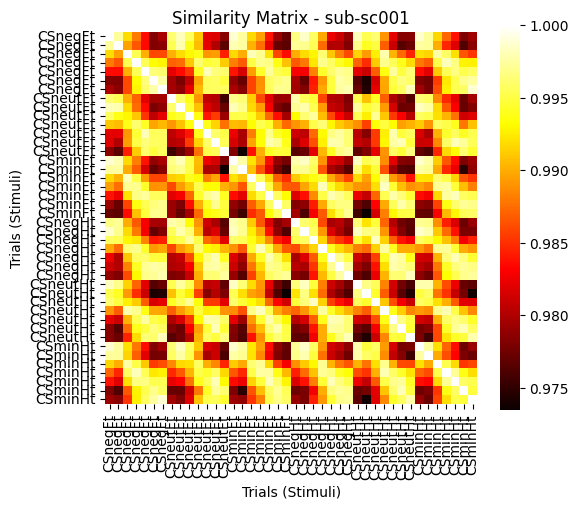

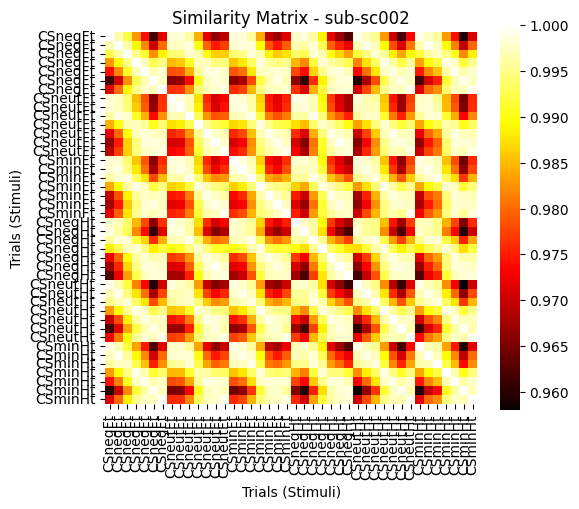

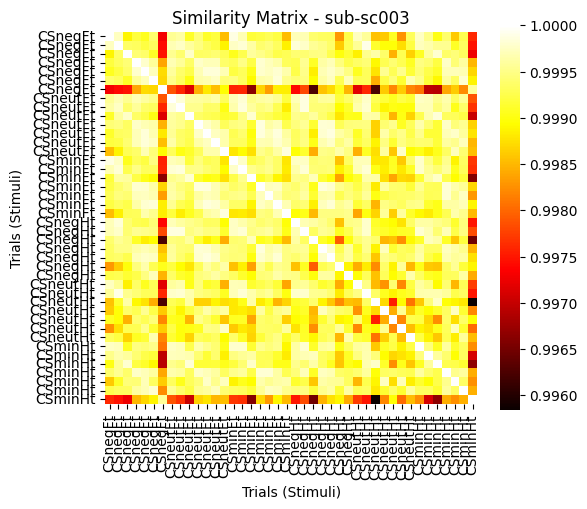

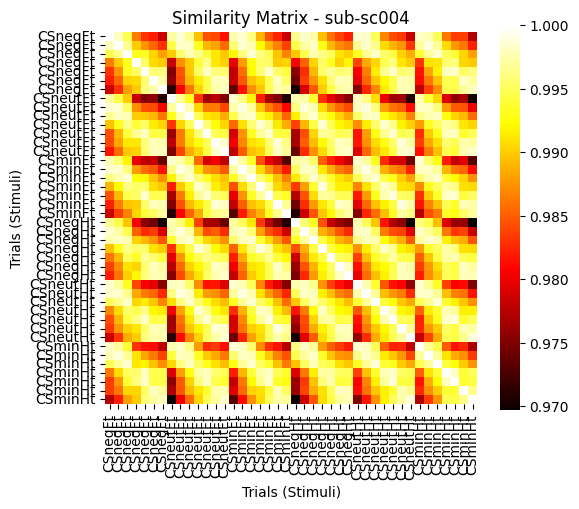

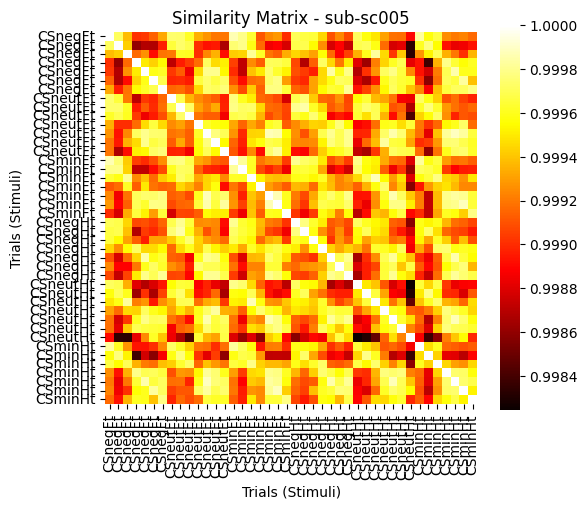

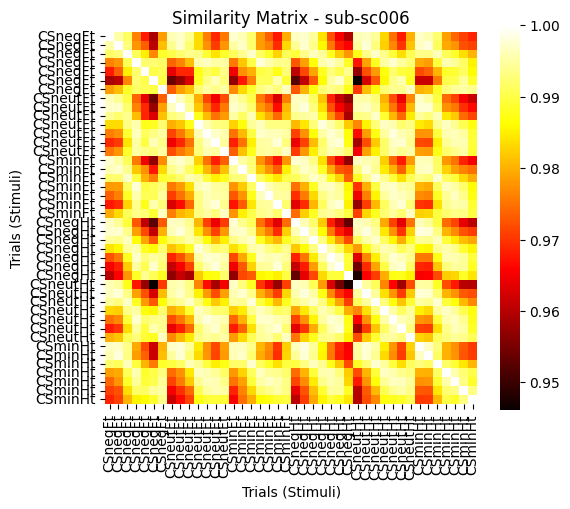

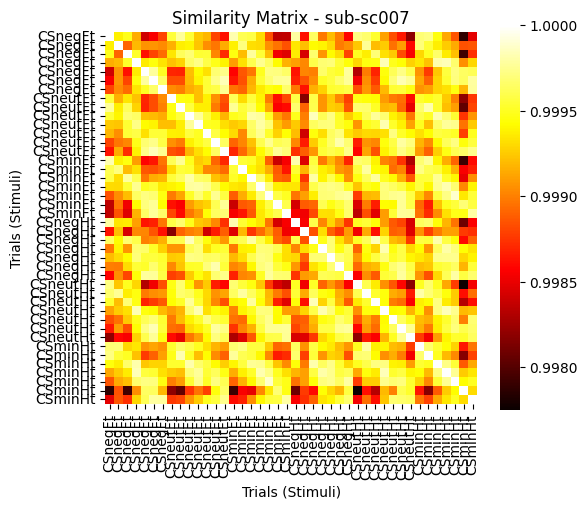

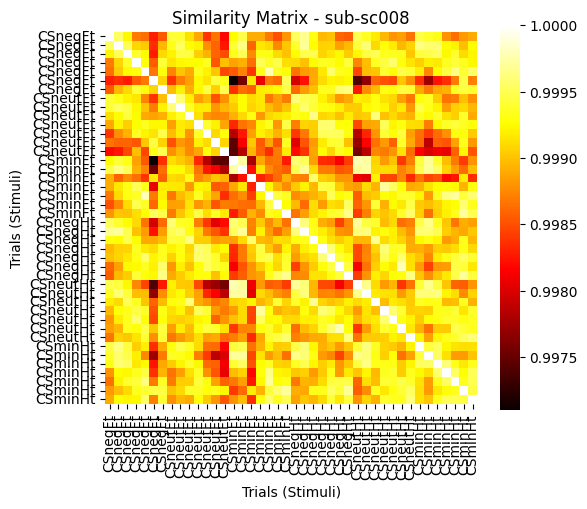

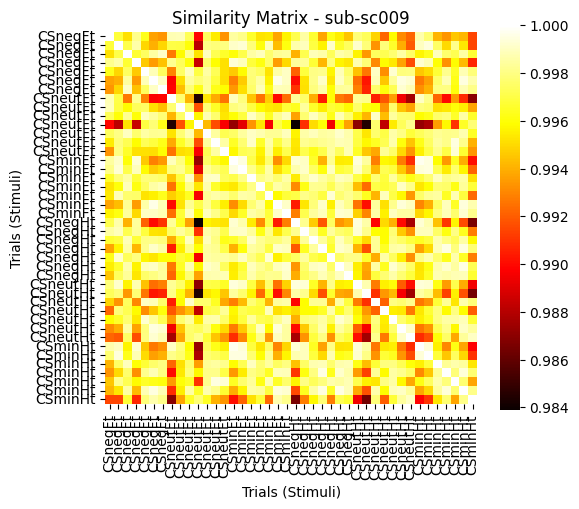

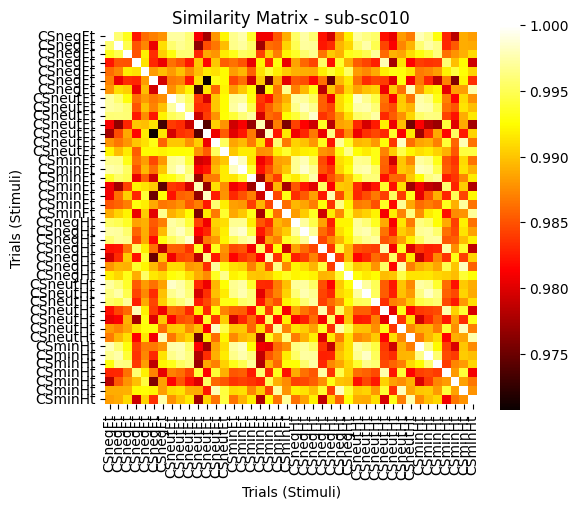

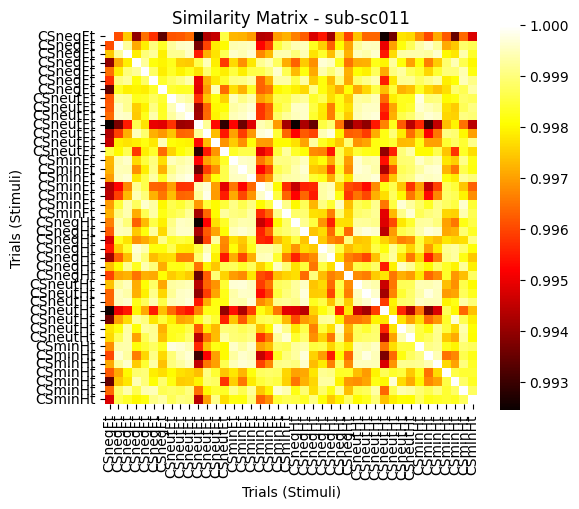

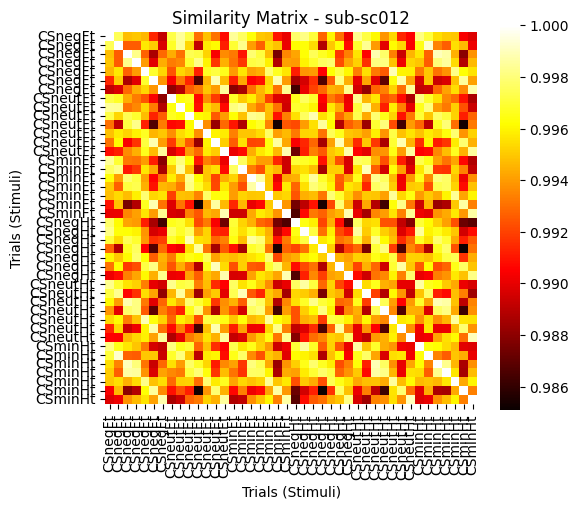

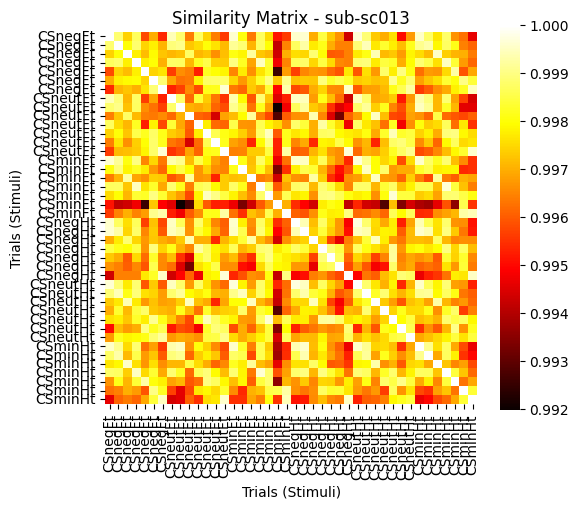

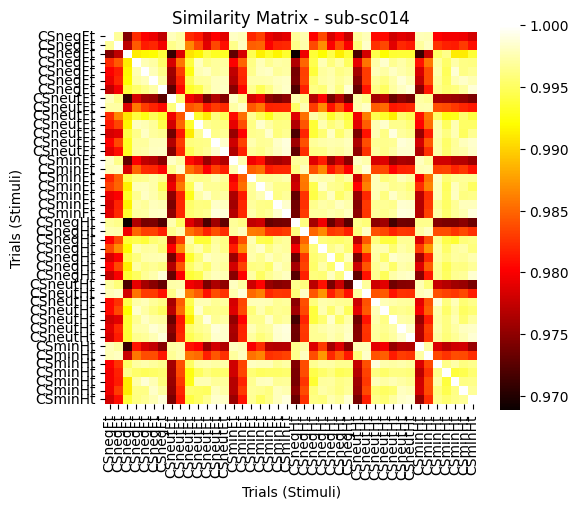

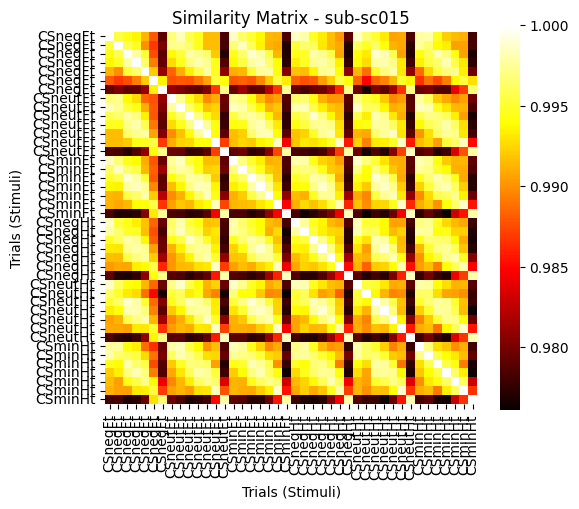

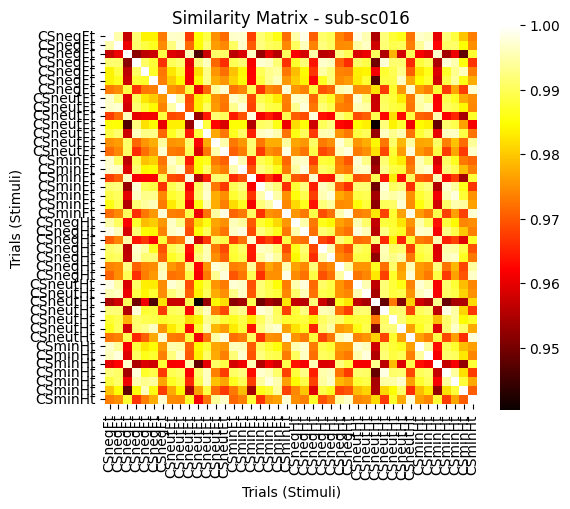

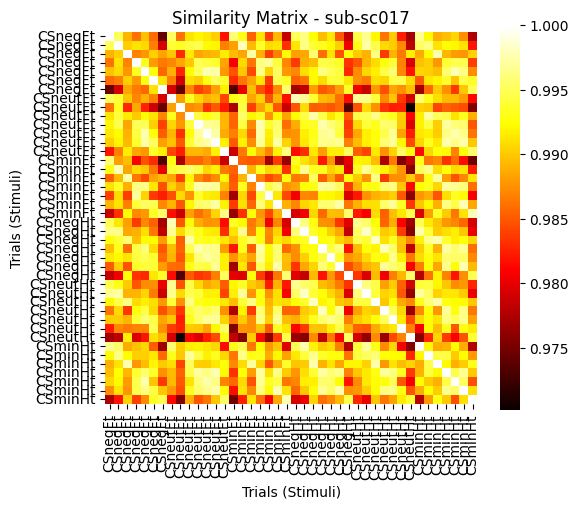

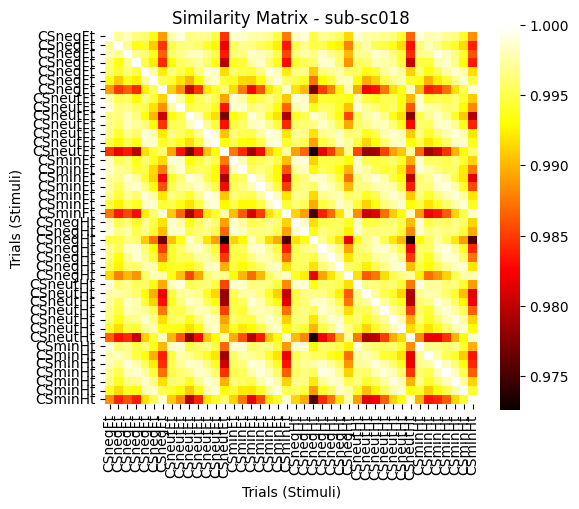

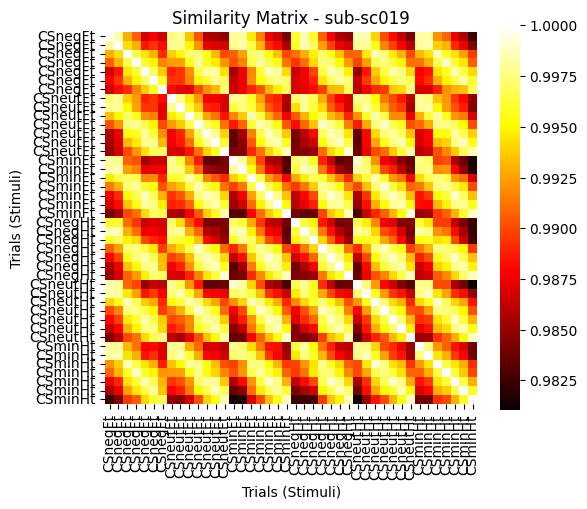

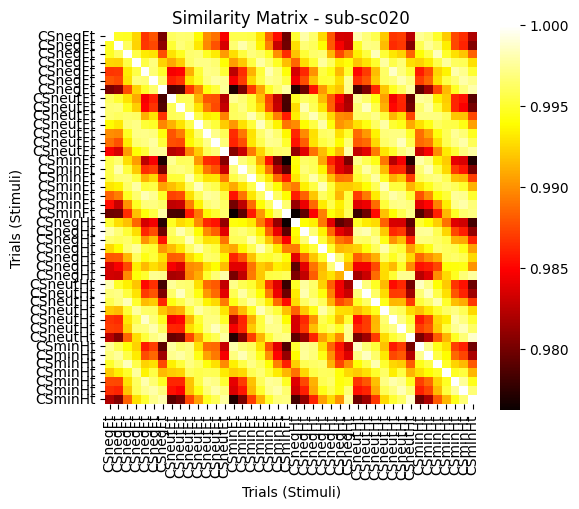

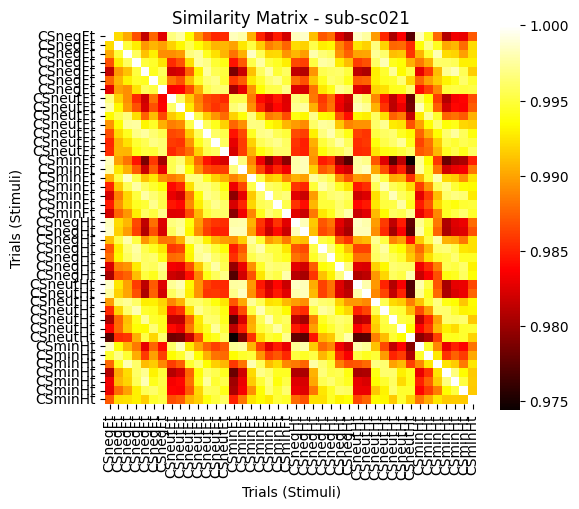

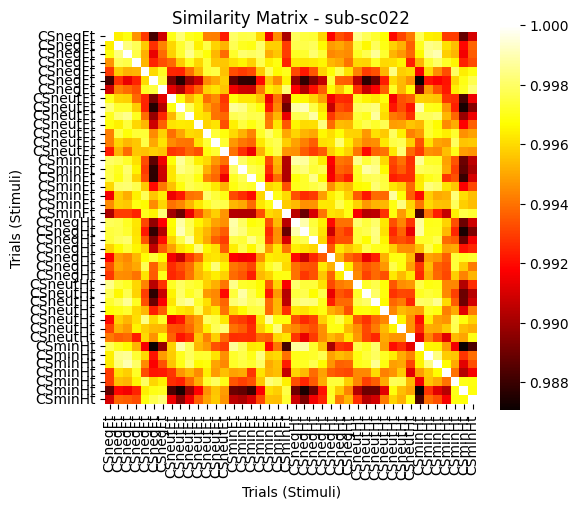

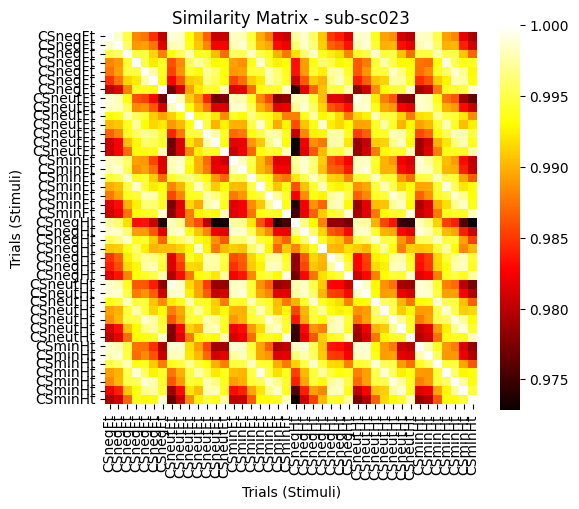

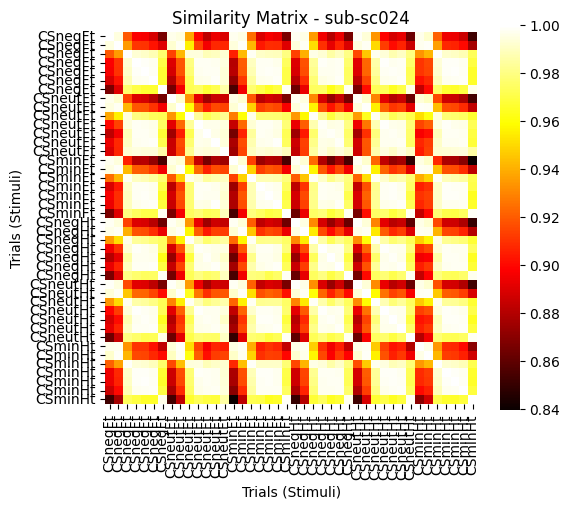

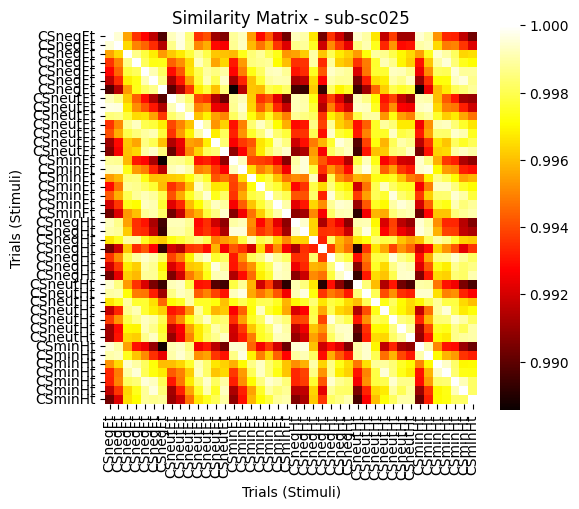

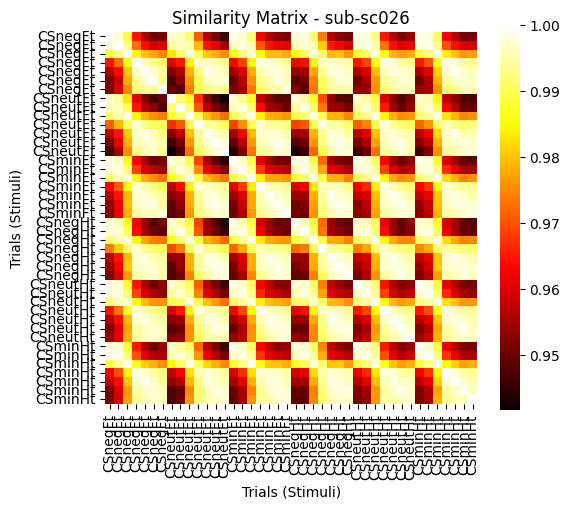

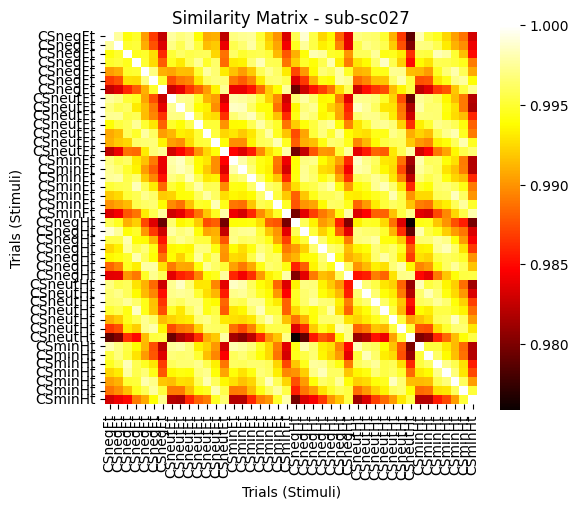

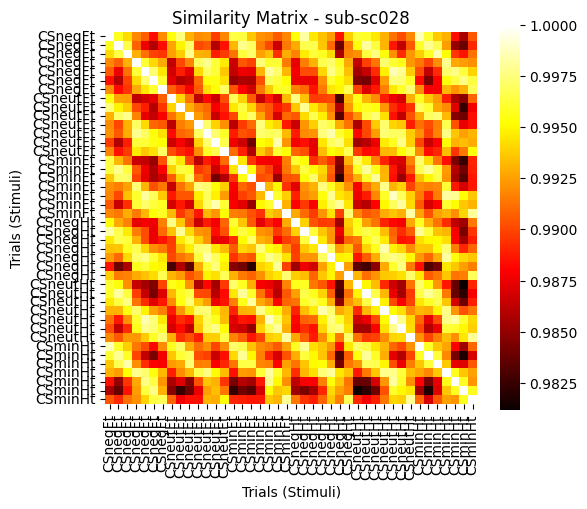

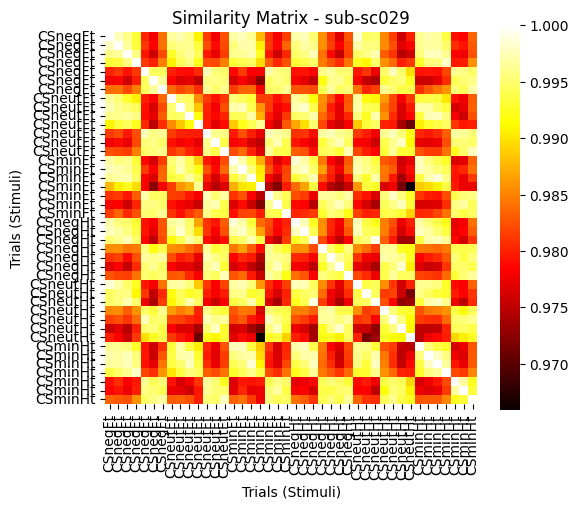

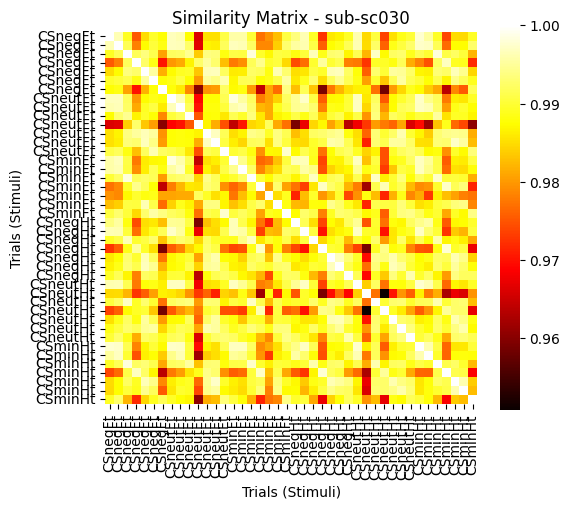

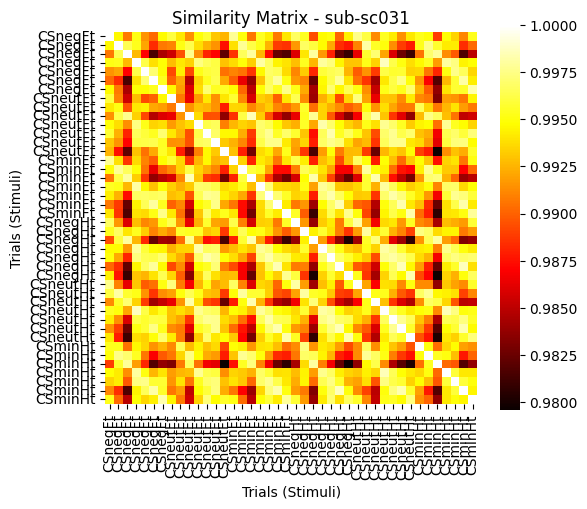

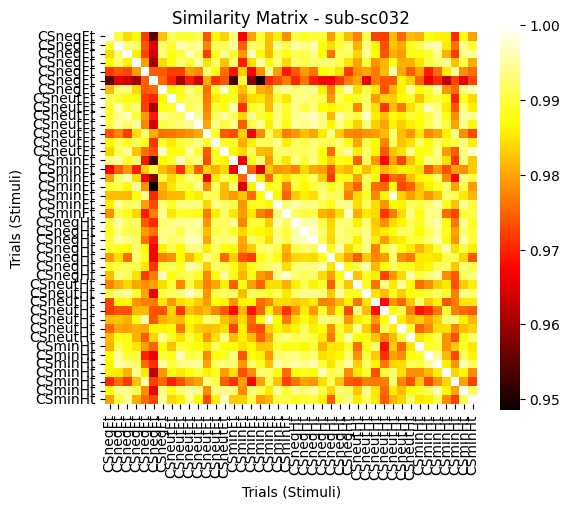

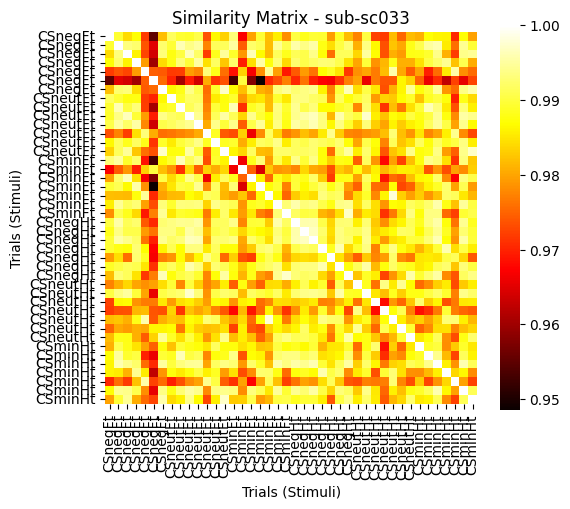

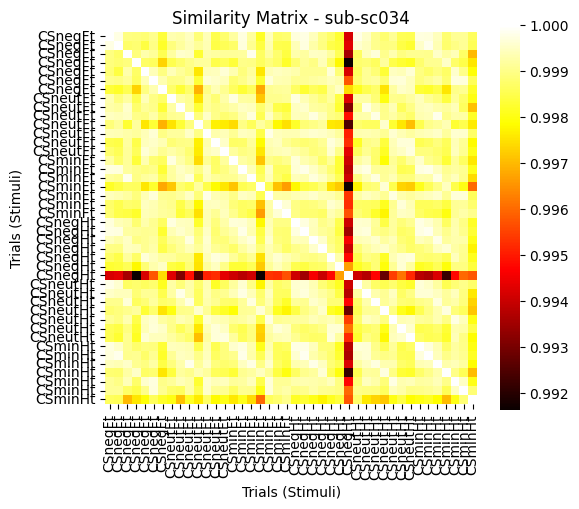

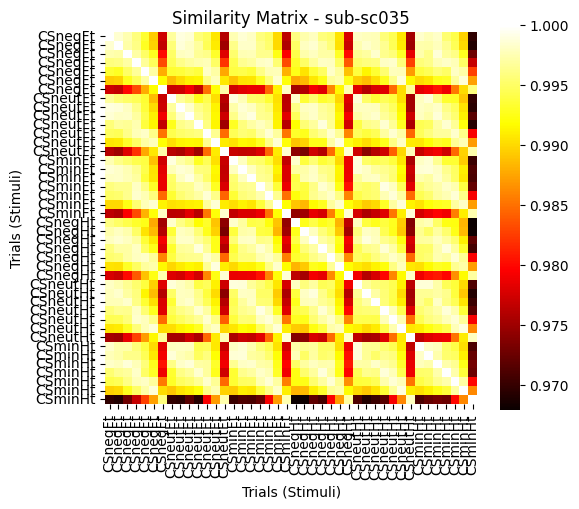

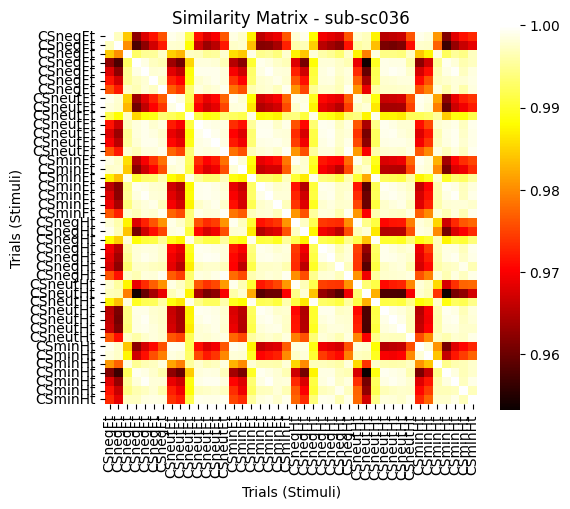

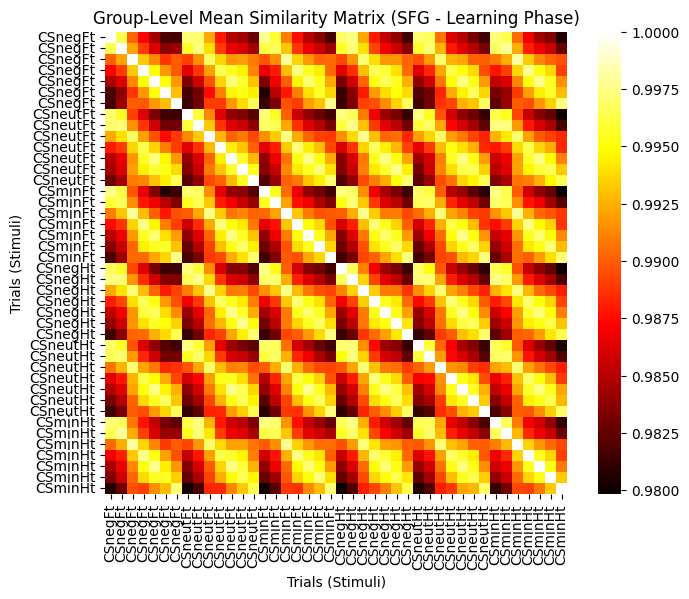

📁 הקובץ 'group_mean_similarity_SFG_learning.csv' נשמר בהצלחה!


In [ ]:
# creating lists for storing the matrices
all_similarity_matrices = []
stimulus_labels = []

# loop over all subjects
for subject in subject_ids:
    # Creating the appropriate file name for each subject (SFG, Learning Phase only)
    file_name = os.path.join(fmri_base_path, f"{subject}_learning_SFG_spatial_patterns.csv")

    # check if file exist, if not - alert and skip
    if not os.path.exists(file_name):
        print(f"❌ file is missing {file_name}, skipping to the next subject..")
        continue

    # load file to csv
    df = pd.read_csv(file_name, index_col=0)  # The rows are trials, the columns are voxels

    # Retrieving the stimulus labels from the index of the CSV file
    trial_labels = df.index.tolist()

    # Saving the stimulus labels for the first time (so that we use them for the average matrix)
    if len(stimulus_labels) == 0:
        stimulus_labels = trial_labels

    # Calculation of the Pearson correlation matrix between every two rows (trials)
    similarity_matrix = np.corrcoef(df.values)

    # Checking that the matrix is ​​the right size (42x42)
    if similarity_matrix.shape != (42, 42):
        print(f"⚠️ Error matrix size for {subject}: {similarity_matrix.shape}, skipping...")
        continue

    # Adding the matrix to the list
    all_similarity_matrices.append(similarity_matrix)

    # Heatmap display for each subject with stimulus labels
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(similarity_matrix, cmap="hot", square=True, cbar=True, xticklabels=trial_labels, yticklabels=trial_labels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f"Similarity Matrix - {subject}")
    plt.xlabel("Trials (Stimuli)")
    plt.ylabel("Trials (Stimuli)")
    plt.show()

# If there are not enough subjects, exit the loop
if len(all_similarity_matrices) == 0:
    print("❌ No valid files found, check the data!")
    exit()

# Calculation of the average of the matrices for all subjects
group_similarity_matrix = np.mean(all_similarity_matrices, axis=0)

# Showing the group matrix with the stimulus labels
plt.figure(figsize=(8, 6))
ax = sns.heatmap(group_similarity_matrix, cmap="hot", square=True, cbar=True, xticklabels=stimulus_labels, yticklabels=stimulus_labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Group-Level Mean Similarity Matrix (SFG - Learning Phase)")
plt.xlabel("Trials (Stimuli)")
plt.ylabel("Trials (Stimuli)")
plt.show()

# preserving the mean matrix
np.savetxt("group_mean_similarity_SFG_learning.csv", group_similarity_matrix, delimiter=",")
print("📁 the file 'group_mean_similarity_SFG_learning.csv' is saved successfully!")


# within stimulus

mean all subjects all areas, 2 phases

📊 Processing SFG in learning phase
✔ הקובץ 'within_stimulus_similarity_SFG_learning.csv' נשמר בהצלחה!


📊 Processing SFG in memory phase
✔ הקובץ 'within_stimulus_similarity_SFG_memory.csv' נשמר בהצלחה!


📊 Processing ACC in learning phase
✔ הקובץ 'within_stimulus_similarity_ACC_learning.csv' נשמר בהצלחה!


📊 Processing ACC in memory phase
✔ הקובץ 'within_stimulus_similarity_ACC_memory.csv' נשמר בהצלחה!


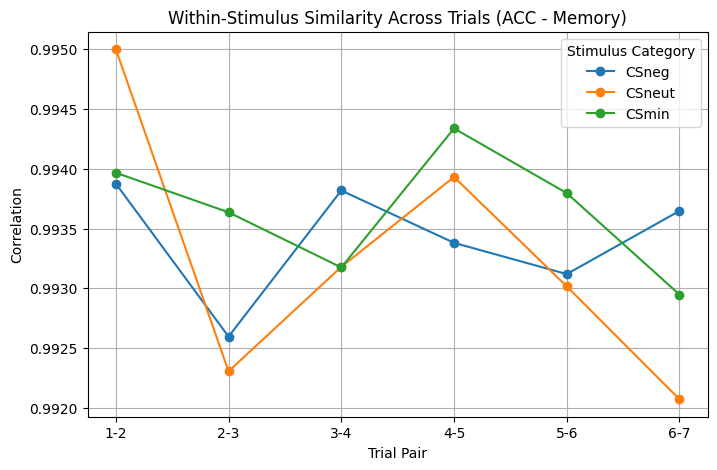

📊 Processing Amygdala in learning phase
✔ הקובץ 'within_stimulus_similarity_Amygdala_learning.csv' נשמר בהצלחה!


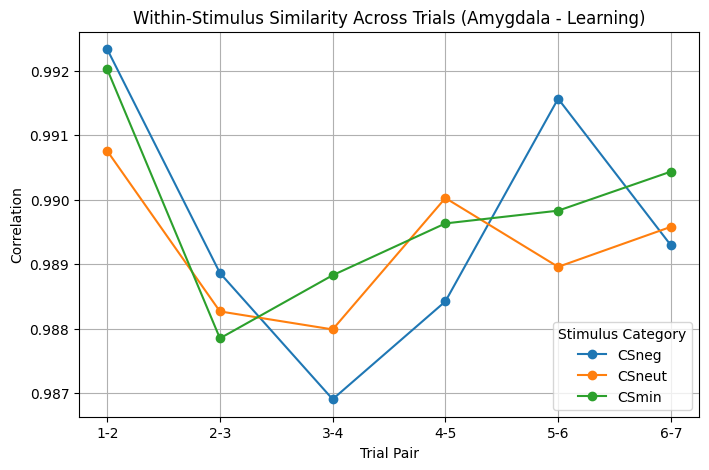

📊 Processing Amygdala in memory phase
✔ הקובץ 'within_stimulus_similarity_Amygdala_memory.csv' נשמר בהצלחה!


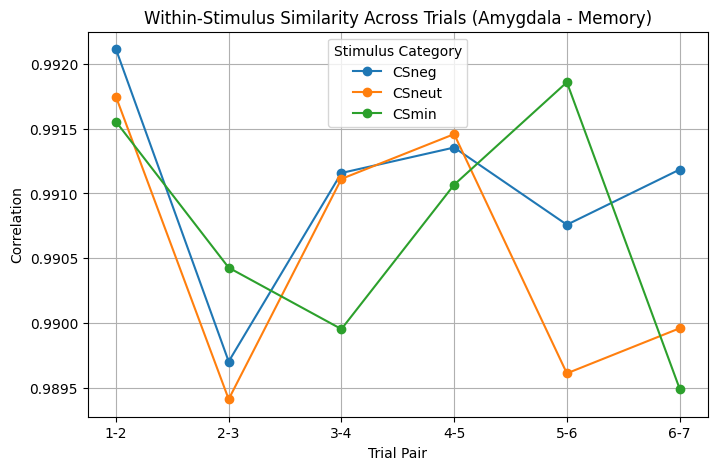

📊 Processing Hippocampus in learning phase
✔ הקובץ 'within_stimulus_similarity_Hippocampus_learning.csv' נשמר בהצלחה!


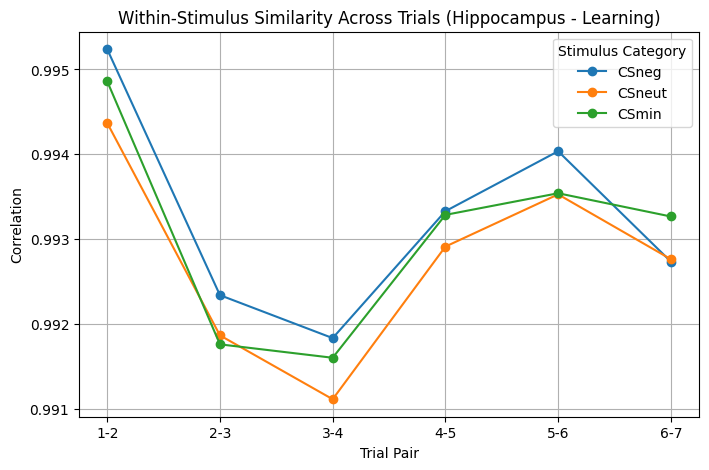

📊 Processing Hippocampus in memory phase
✔ הקובץ 'within_stimulus_similarity_Hippocampus_memory.csv' נשמר בהצלחה!


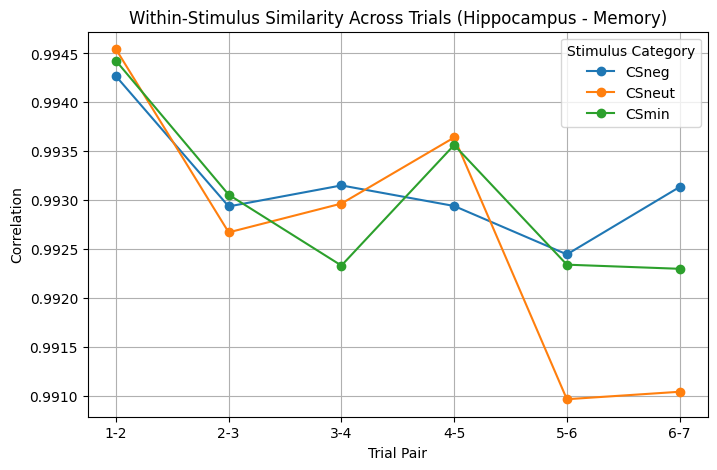

📊 Processing Insula in learning phase
✔ הקובץ 'within_stimulus_similarity_Insula_learning.csv' נשמר בהצלחה!


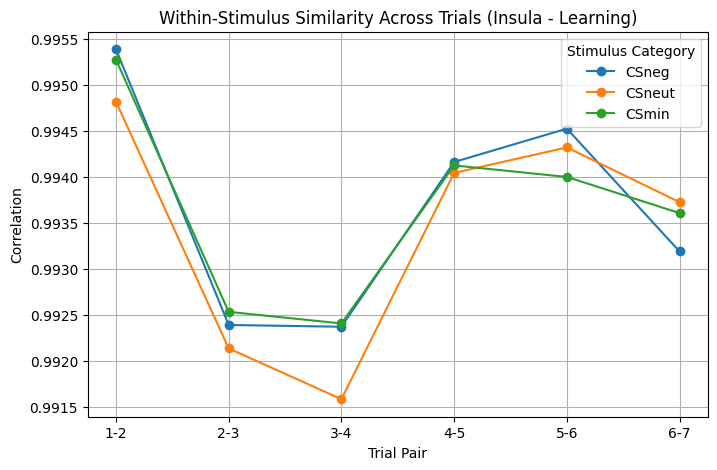

📊 Processing Insula in memory phase
✔ הקובץ 'within_stimulus_similarity_Insula_memory.csv' נשמר בהצלחה!


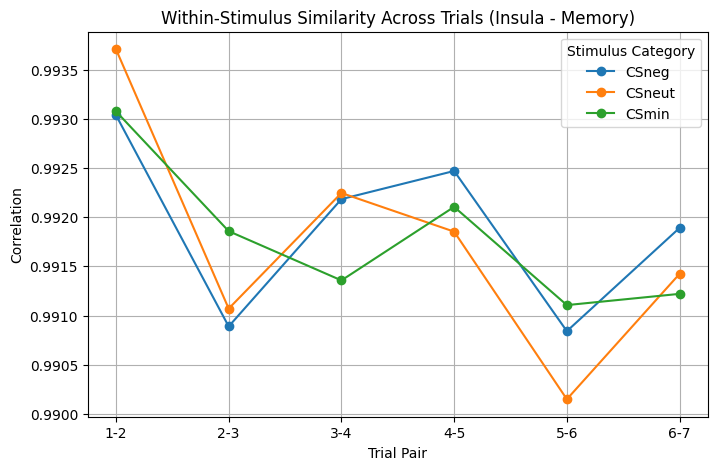

📊 Processing vmPFC in learning phase
✔ הקובץ 'within_stimulus_similarity_vmPFC_learning.csv' נשמר בהצלחה!


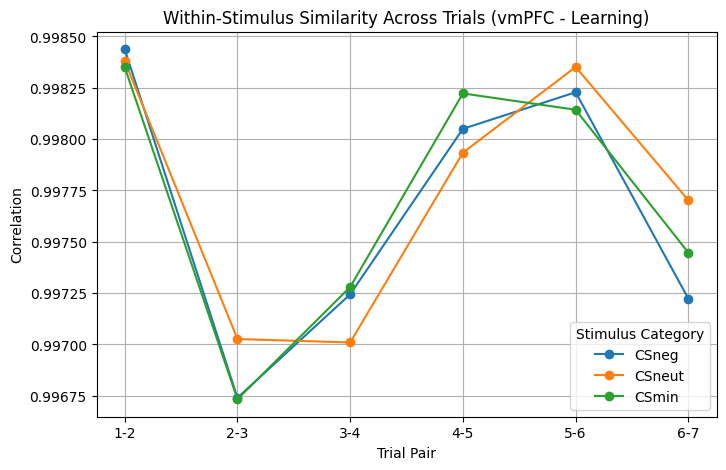

📊 Processing vmPFC in memory phase
✔ הקובץ 'within_stimulus_similarity_vmPFC_memory.csv' נשמר בהצלחה!


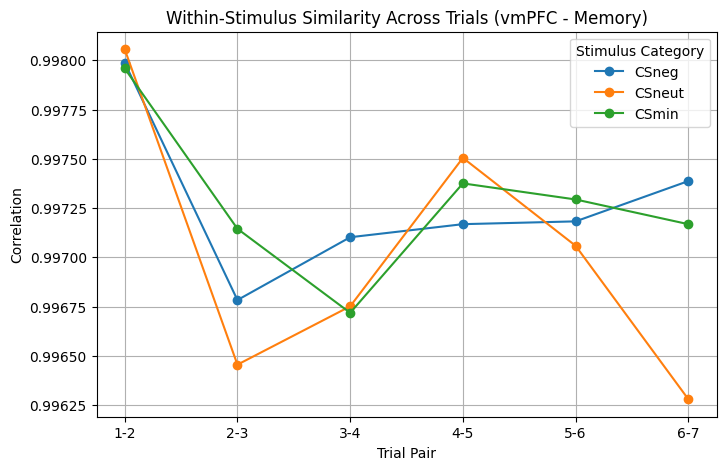

In [ ]:
# List of experimental steps
experiment_phases = ["learning", "memory"]

# List of all ROI regions
roi_names = ["SFG", "ACC", "Amygdala", "Hippocampus", "Insula", "vmPFC"]

# List of all types of stimuli (according to the article)
stimulus_types = ["CSnegFt", "CSneutFt", "CSminFt", "CSnegHt", "CSneutHt", "CSminHt"]

# Go over all ROI areas
for roi_name in roi_names:
    for phase in experiment_phases:
        print(f"📊 Processing {roi_name} in {phase} phase")

        # A dictionary to store the correlations for each stimulus and each subject
        within_stimulus_results = {stim: [] for stim in stimulus_types}

        # loop over all subjects
        for subject in subject_ids:
            # Creating the appropriate file name for each subject
            file_name = os.path.join(fmri_base_path, f"{subject}_{phase}_{roi_name}_spatial_patterns.csv")

            # Checking if the file exists
            if not os.path.exists(file_name):
                print(f"❌ file is missing {file_name}, skipping to the next subject..")
                continue

            # load data
            df = pd.read_csv(file_name, index_col=0)

            # save trials names
            trial_labels = df.index.tolist()

            # Going over each stimulus type and calculating correlations between successive trials
            for stim in stimulus_types:
                # Retrieving the indexes of all trails with the same stimulus
                stim_indices = [i for i, label in enumerate(trial_labels) if label == stim]

                # If there are less than 2 appearances of the stimulus → proceed to the next stimulus
                if len(stim_indices) < 2:
                    continue

                # Calculation of Pearson correlation between consecutive trials
                corrs = []
                for i in range(len(stim_indices) - 1):
                    idx1, idx2 = stim_indices[i], stim_indices[i + 1]
                    corr = np.corrcoef(df.iloc[idx1].values, df.iloc[idx2].values)[0, 1]
                    corrs.append(corr)

                # Saving the correlations for each subject
                within_stimulus_results[stim].append(corrs)

        # Calculating the average of the correlations for each stimulus
        mean_within_stimulus = {stim: np.mean(within_stimulus_results[stim], axis=0) for stim in stimulus_types}

        # Saving the data to a CSV file
        within_df = pd.DataFrame(mean_within_stimulus)
        output_file = f"within_stimulus_similarity_{roi_name}_{phase}.csv"
        within_df.to_csv(output_file, index=False)
        print(f"✔ הקובץ '{output_file}' נשמר בהצלחה!")

        # Averaging the groups (CSneg, CSneut, CSmin)
        grouped_results = {
            "CSneg": np.mean([mean_within_stimulus["CSnegFt"], mean_within_stimulus["CSnegHt"]], axis=0),
            "CSneut": np.mean([mean_within_stimulus["CSneutFt"], mean_within_stimulus["CSneutHt"]], axis=0),
            "CSmin": np.mean([mean_within_stimulus["CSminFt"], mean_within_stimulus["CSminHt"]], axis=0),
        }

        # Creating a group graph
        plt.figure(figsize=(8, 5))

        # X-axis: the numbers of trail pairs
        trial_pairs = ["1-2", "2-3", "3-4", "4-5", "5-6", "6-7"]

        # Going over the three new categories and creating a line in the graph
        for stim, mean_corrs in grouped_results.items():
            plt.plot(trial_pairs, mean_corrs, marker="o", linestyle="-", label=stim)

        plt.xlabel("Trial Pair")
        plt.ylabel("Correlation")
        plt.title(f"Within-Stimulus Similarity Across Trials ({roi_name} - {phase.capitalize()})")
        plt.legend(title="Stimulus Category")
        plt.grid(True)
        plt.show()


# Between Stimulus

In [ ]:
# List of learning categories
stimulus_categories = {
    "CSneg": ["CSnegFt", "CSnegHt"],
    "CSneut": ["CSneutFt", "CSneutHt"],
    "CSmin": ["CSminFt", "CSminHt"]
}

# A dictionary to store the results for each stage, region and category
between_stimulus_results = {phase: {roi: {cat: [] for cat in stimulus_categories} for roi in roi_names} for phase in experiment_phases}

# Go through all the stages of the experiment (learning + memory)
for phase in experiment_phases:
    for roi in roi_names:
        for subject in subject_ids:
            # Creating a file name suitable for the subject and stage
            file_name = os.path.join(fmri_base_path, f"{subject}{phase}{roi}_spatial_patterns.csv")

            # Checking if the file exists
            if not os.path.exists(file_name):
                print(f"❌ file is missing: {file_name}, skipping to the next subject..")
                continue

            #  load data
            df = pd.read_csv(file_name, index_col=0)
            trial_labels = df.index.tolist()

            # loop over each learning category (CSneg, CSneut, CSmin)
            for category, stimuli in stimulus_categories.items():
                # Finding indexes of the trails according to the order of appearance
                stim1_trials = [i for i, label in enumerate(trial_labels) if label == stimuli[0]]
                stim2_trials = [i for i, label in enumerate(trial_labels) if label == stimuli[1]]

                # Make sure there are enough trailers of each type
                if len(stim1_trials) < 7 or len(stim2_trials) < 7:
                    continue

                # Calculation of Pearson correlation between each pair of trails that appeared in the same order
                corrs = []
                for trial_num in range(7):
                    idx1 = stim1_trials[trial_num]
                    idx2 = stim2_trials[trial_num]

                    # Calculation of the Pearson correlation between the two trails
                    corr = np.corrcoef(df.iloc[idx1].values, df.iloc[idx2].values)[0, 1]
                    corrs.append(corr)

                # Saving the average of the correlations for each subject
                between_stimulus_results[phase][roi][category].append(corrs)

# Average calculation Across Subjects
group_mean_between_stimulus = {
    phase: {
        roi: {cat: np.mean(between_stimulus_results[phase][roi][cat], axis=0) for cat in stimulus_categories}
        for roi in roi_names
    }
    for phase in experiment_phases
}

# Saving the results to a CSV file
output_data = []

for phase in experiment_phases:
    for roi in roi_names:
        for category, mean_corrs in group_mean_between_stimulus[phase][roi].items():
            for trial_idx, value in enumerate(mean_corrs):
                output_data.append([phase, roi, category, trial_idx + 1, value])

# Convert the data to a DataFrame
output_df = pd.DataFrame(output_data, columns=["Phase", "ROI", "Stimulus_Category", "Trial", "Correlation"])

# Saving the data to a file
output_df.to_csv("between_stimulus_similarity.csv", index=False)
print("✔ the file 'between_stimulus_similarity.csv' saved successfully")

# Creating graphs - as in the article (Figure 2)
for phase in experiment_phases:
    for roi in roi_names:
        plt.figure(figsize=(8, 5))

        # X-axis: trial number
        trial_numbers = np.arange(1, 8)  #  7 trials

        # Going over the three categories (CSneg, CSneut, CSmin) and creating a line in the graph
        for category, mean_corrs in group_mean_between_stimulus[phase][roi].items():
            plt.plot(trial_numbers, mean_corrs, marker="o", linestyle="-", label=category)

        # plot
        plt.xlabel("Trial Number")
        plt.ylabel("Between-Stimulus Correlation")
        plt.title(f"{phase.capitalize()} Phase - Between-Stimulus Similarity ({roi})")
        plt.legend(title="Stimulus Category")
        plt.grid(True)
        plt.show()

# ANOVA

In [ ]:
# Load the results (assume the file is already created)
data = pd.read_csv("between_stimulus_similarity.csv")

# Displaying the column names and checking the data types
print("Columns in dataset:", data.columns)
print("Data types:\n", data.dtypes)

# Convert "Correlation" column to numbers
data["Correlation"] = pd.to_numeric(data["Correlation"], errors="coerce")

# Convert the data into a format suitable for ANOVA (Long Format)
data_long = data.melt(id_vars=["Phase", "ROI", "Stimulus_Category", "Trial"],
                      var_name="Measure",
                      value_name="Corr_Value")

# Convert "Corr_Value" column to numbers
data_long["Corr_Value"] = pd.to_numeric(data_long["Corr_Value"], errors="coerce")

# Performing a within-subjects ANOVA
anova_results = pg.rm_anova(dv="Corr_Value",
                            within=["Stimulus_Category", "Phase"],
                            subject="Trial",
                            data=data_long,
                            detailed=True)

# results
print("\n📊 ANOVA Results:")
print(anova_results)

# If a significant effect is found, pairwise T-tests with correction for multiple tests are performed
if any(anova_results["p-GG-corr"] < 0.05):
    pairwise_results = pg.pairwise_ttests(dv="Corr_Value",
                                          within=["Stimulus_Category", "Phase"],
                                          subject="Trial",
                                          data=data_long,
                                          padjust="bonferroni")
    print("\n📊 Pairwise T-tests:")
    print(pairwise_results)

# plot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Stimulus_Category", y="Corr_Value", hue="Phase", data=data_long)
plt.title("Between-Stimulus Similarity Across Phases")
plt.xlabel("Stimulus Category")
plt.ylabel("Correlation")
plt.legend(title="Phase")
plt.grid(True)
plt.show()